In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from source.features_selection import get_feature_lag_config
from source.Tools import setup_device_and_seed
from source.prepare_data import load_and_preprocess_data
from source.join_qh_min_data import join_qh_min_data

from statsmodels.tsa.stattools import pacf


Setup

In [2]:
device_info = setup_device_and_seed(seed=987)
device = device_info["device"]
qh,minute,hour =load_and_preprocess_data(system_imbalance_analysis=True) #2020.01.01_to_2023.12.31; choose the right one!
qh_cleaned = qh.drop(columns=["Hour_sin", "Hour_cos","DayOfWeek_sin",
                              "DayOfWeek_cos", "Month_sin", "Month_cos"])
# Define target columns for each dataset
target_qh = "system_imbalance"
target_minute = "system_imbalance_min"
forecast_horizon = 1
qh_parameters, minute_parameters, hour_parameters = get_feature_lag_config(forecast_horizon, 1)

colors = [
    "#52BDEC",  # Light Blue (Logo)
    "#00407A",  # Dark Blue (Logo)
    "#1FABD5",  # Bright Cyan (Grid)
    "#1D8DB0",  # Muted Teal (Grid)
    "#116E8A"   # Dark Teal (Grid)
]
color = "#1FABD5"


Using device: cuda
Current device index: 0, GPU name: NVIDIA GeForce RTX 3050 6GB Laptop GPU
Loading data from: C:\Users\jds\OneDrive - KU Leuven\Ku Leuven\Master Semester 5\Thesis\Elia\CSV\quarter_hours_data_2020.01.01_to_2023.12.31.h5
Loading data from: C:\Users\jds\OneDrive - KU Leuven\Ku Leuven\Master Semester 5\Thesis\Elia\CSV\minutes_data_2022.01.01_to_2023.12.31.h5
Loading data from: C:\Users\jds\OneDrive - KU Leuven\Ku Leuven\Master Semester 5\Thesis\Elia\CSV\quarter_hours_data_2020.01.01_to_2023.12.31.h5


plot system imbalance & 10 month centered average

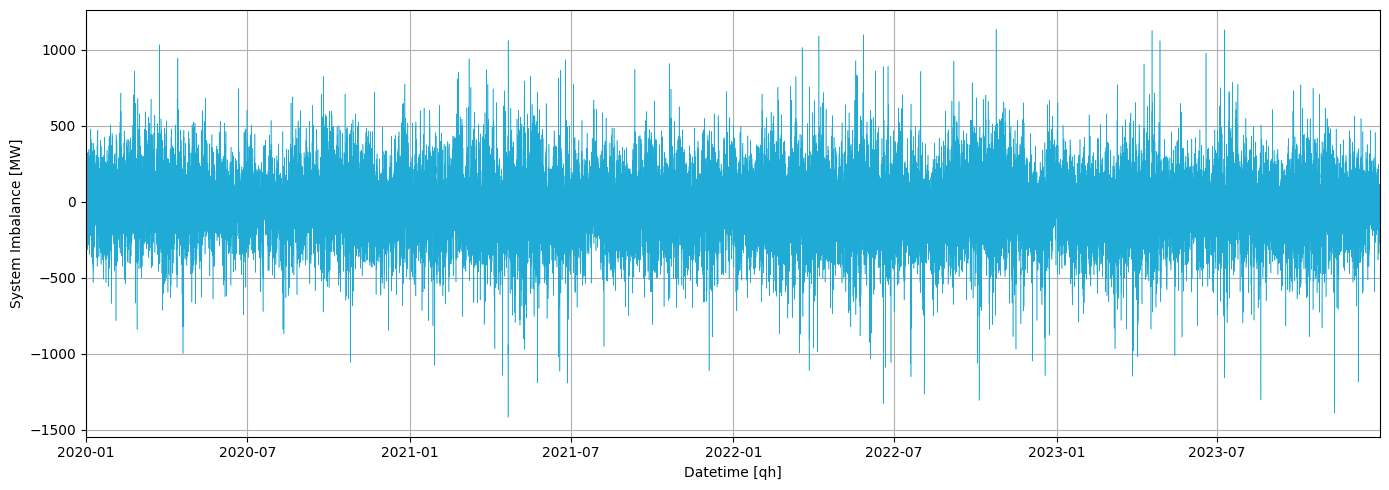

In [143]:
# Ensure the index is datetime
output= False
qh = qh.copy()
if not isinstance(qh.index, pd.DatetimeIndex):
    qh.index = pd.to_datetime(qh.index)
# Filter data for 2023
qh_2023 = qh[qh.index.year == 2023]

# Loop over colors
fig, ax = plt.subplots(figsize=(14, 5))
plt.plot(qh.index, qh["system_imbalance"], color=color, linewidth=0.4)
plt.xlabel("Datetime [qh]")
plt.ylabel("System Imbalance [MW]")
plt.grid(True)
ax.set_xlim(qh.index.min(), qh.index.max())
plt.tight_layout()
plt.show()

# Save if output is True
if output:
    hex_clean = color.replace("#", "")
    fig.savefig(f"/Users/jds/Desktop/fig1.png", dpi=300)

In [144]:
# Ensure datetime index
qh = qh.copy()
if not isinstance(qh.index, pd.DatetimeIndex):
    qh.index = pd.to_datetime(qh.index)

# Initialize container for stats
years = [2020, 2021, 2022, 2023]
stats = {}
# Calculate mean and median
mean_si = qh["system_imbalance"].mean()
median_si = qh["system_imbalance"].median()
max_si = qh["system_imbalance"].max()
min_si = qh["system_imbalance"].min()

print(f"Mean: {mean_si:.2f} MW")
print(f"Median: {median_si:.2f} MW")
print(f"Max: {max_si:.2f} MW")
print(f"Min: {min_si:.2f} MW")

for year in years:
    data_year = qh[qh.index.year == year]["system_imbalance"]
    stats[year] = {
        "Average": data_year.mean(),
        "Standard Deviation": data_year.std(),
        "25th Quantile": data_year.quantile(0.25),
        "50th Quantile": data_year.quantile(0.50),
        "75th Quantile": data_year.quantile(0.75),
    }

#Combine 2022 and 2023
data_22_23 = qh[qh.index.year.isin([2022, 2023])]["system_imbalance"]
stats["2022–2023"] = {
    "Average": data_22_23.mean(),
    "Standard Deviation": data_22_23.std(),
    "25th Quantile": data_22_23.quantile(0.25),
    "50th Quantile": data_22_23.quantile(0.50),
    "75th Quantile": data_22_23.quantile(0.75),
}
#Combine 2022 and 2023
data_20_23 = qh[qh.index.year.isin([2020,2021,2022, 2023])]["system_imbalance"]
stats["2020–2023"] = {
    "Average": data_20_23.mean(),
    "Standard Deviation": data_20_23.std(),
    "25th Quantile": data_20_23.quantile(0.25),
    "50th Quantile": data_20_23.quantile(0.50),
    "75th Quantile": data_20_23.quantile(0.75),
}

# Convert to DataFrame for easy display or export
stats_df = pd.DataFrame(stats).T.round(2)
print(stats_df)


Mean: -21.35 MW
Median: -15.41 MW
Max: 1135.15 MW
Min: -1419.71 MW
           Average  Standard Deviation  25th Quantile  50th Quantile  \
2020         -0.14              155.68         -83.65           3.76   
2021        -29.56              174.07        -126.18         -23.01   
2022        -26.33              185.84        -128.36         -21.79   
2023        -29.41              161.34        -111.56         -21.74   
2022–2023   -27.87              174.02        -119.66         -21.76   
2020–2023   -21.35              170.07        -112.30         -15.42   

           75th Quantile  
2020               86.81  
2021               66.37  
2022               79.60  
2023               58.65  
2022–2023          68.49  
2020–2023          73.36  


In [145]:
from scipy import stats
# Extract the signal
si_full = qh["system_imbalance"]
qh.index = pd.to_datetime(qh.index)
si_2022_full = qh.loc["2022", "system_imbalance"]


# Count NA values
num_na = si_full.isna().sum()
num_total = len(si_full)
na_percent = 100 * num_na / num_total

# Drop NAs for statistics
si = si_full.dropna()


# Basic stats
basic_stats = si.describe()

# Extended stats
extended_stats = {
    "missing_values": num_na,
    "missing_percent": round(na_percent, 2),
    "mean": si.mean(),
    "median": si.median(),
    "mode": si.mode().iloc[0] if not si.mode().empty else np.nan,
    "std": si.std(),
    "min": si.min(),
    "max": si.max(),
    "range": si.max() - si.min(),
    "skewness": stats.skew(si),
    "kurtosis": stats.kurtosis(si),  # excess kurtosis
    "IQR": si.quantile(0.75) - si.quantile(0.25),
    "IQR_75": si.quantile(0.75),
    "IQR_25": si.quantile(0.25)
}

# Combine for display
summary_df = pd.Series(extended_stats).to_frame("System Imbalance Stats")
display(summary_df)
lower = si.mean() - 1.96 * si.std()
upper = si.mean() + 1.96 * si.std()
print(f"95% interval: {lower:.2f} to {upper:.2f} MW")
share_in_range = ((si_full >= -300) & (si_full <= 300)).mean() * 100
print(f"{share_in_range:.2f}% of the values lie between -300 and +300 MW.")
share_in_range = ((si_full >= -400) & (si_full <= 400)).mean() * 100
print(f"{share_in_range:.2f}% of the values lie between -400 and +400 MW.")

,System Imbalance Stats
missing_values,0.000000
missing_percent,0.000000
mean,-21.346433
median,-15.415000
mode,-50.690000
std,170.070004
min,-1419.710000
max,1135.153000
range,2554.863000
skewness,-0.230602


95% interval: -354.68 to 311.99 MW
92.04% of the values lie between -300 and +300 MW.
96.81% of the values lie between -400 and +400 MW.


In [146]:
from statsmodels.tsa.stattools import adfuller

# Drop NA values
si = qh["system_imbalance"].dropna()

# Run ADF test
adf_result = adfuller(si)

# Print results
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value:       {adf_result[1]:.10g}")
print("Critical values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")


ADF Statistic: -33.6906
p-value:       0
Critical values:
   1%: -3.4304
   5%: -2.8616
   10%: -2.5668


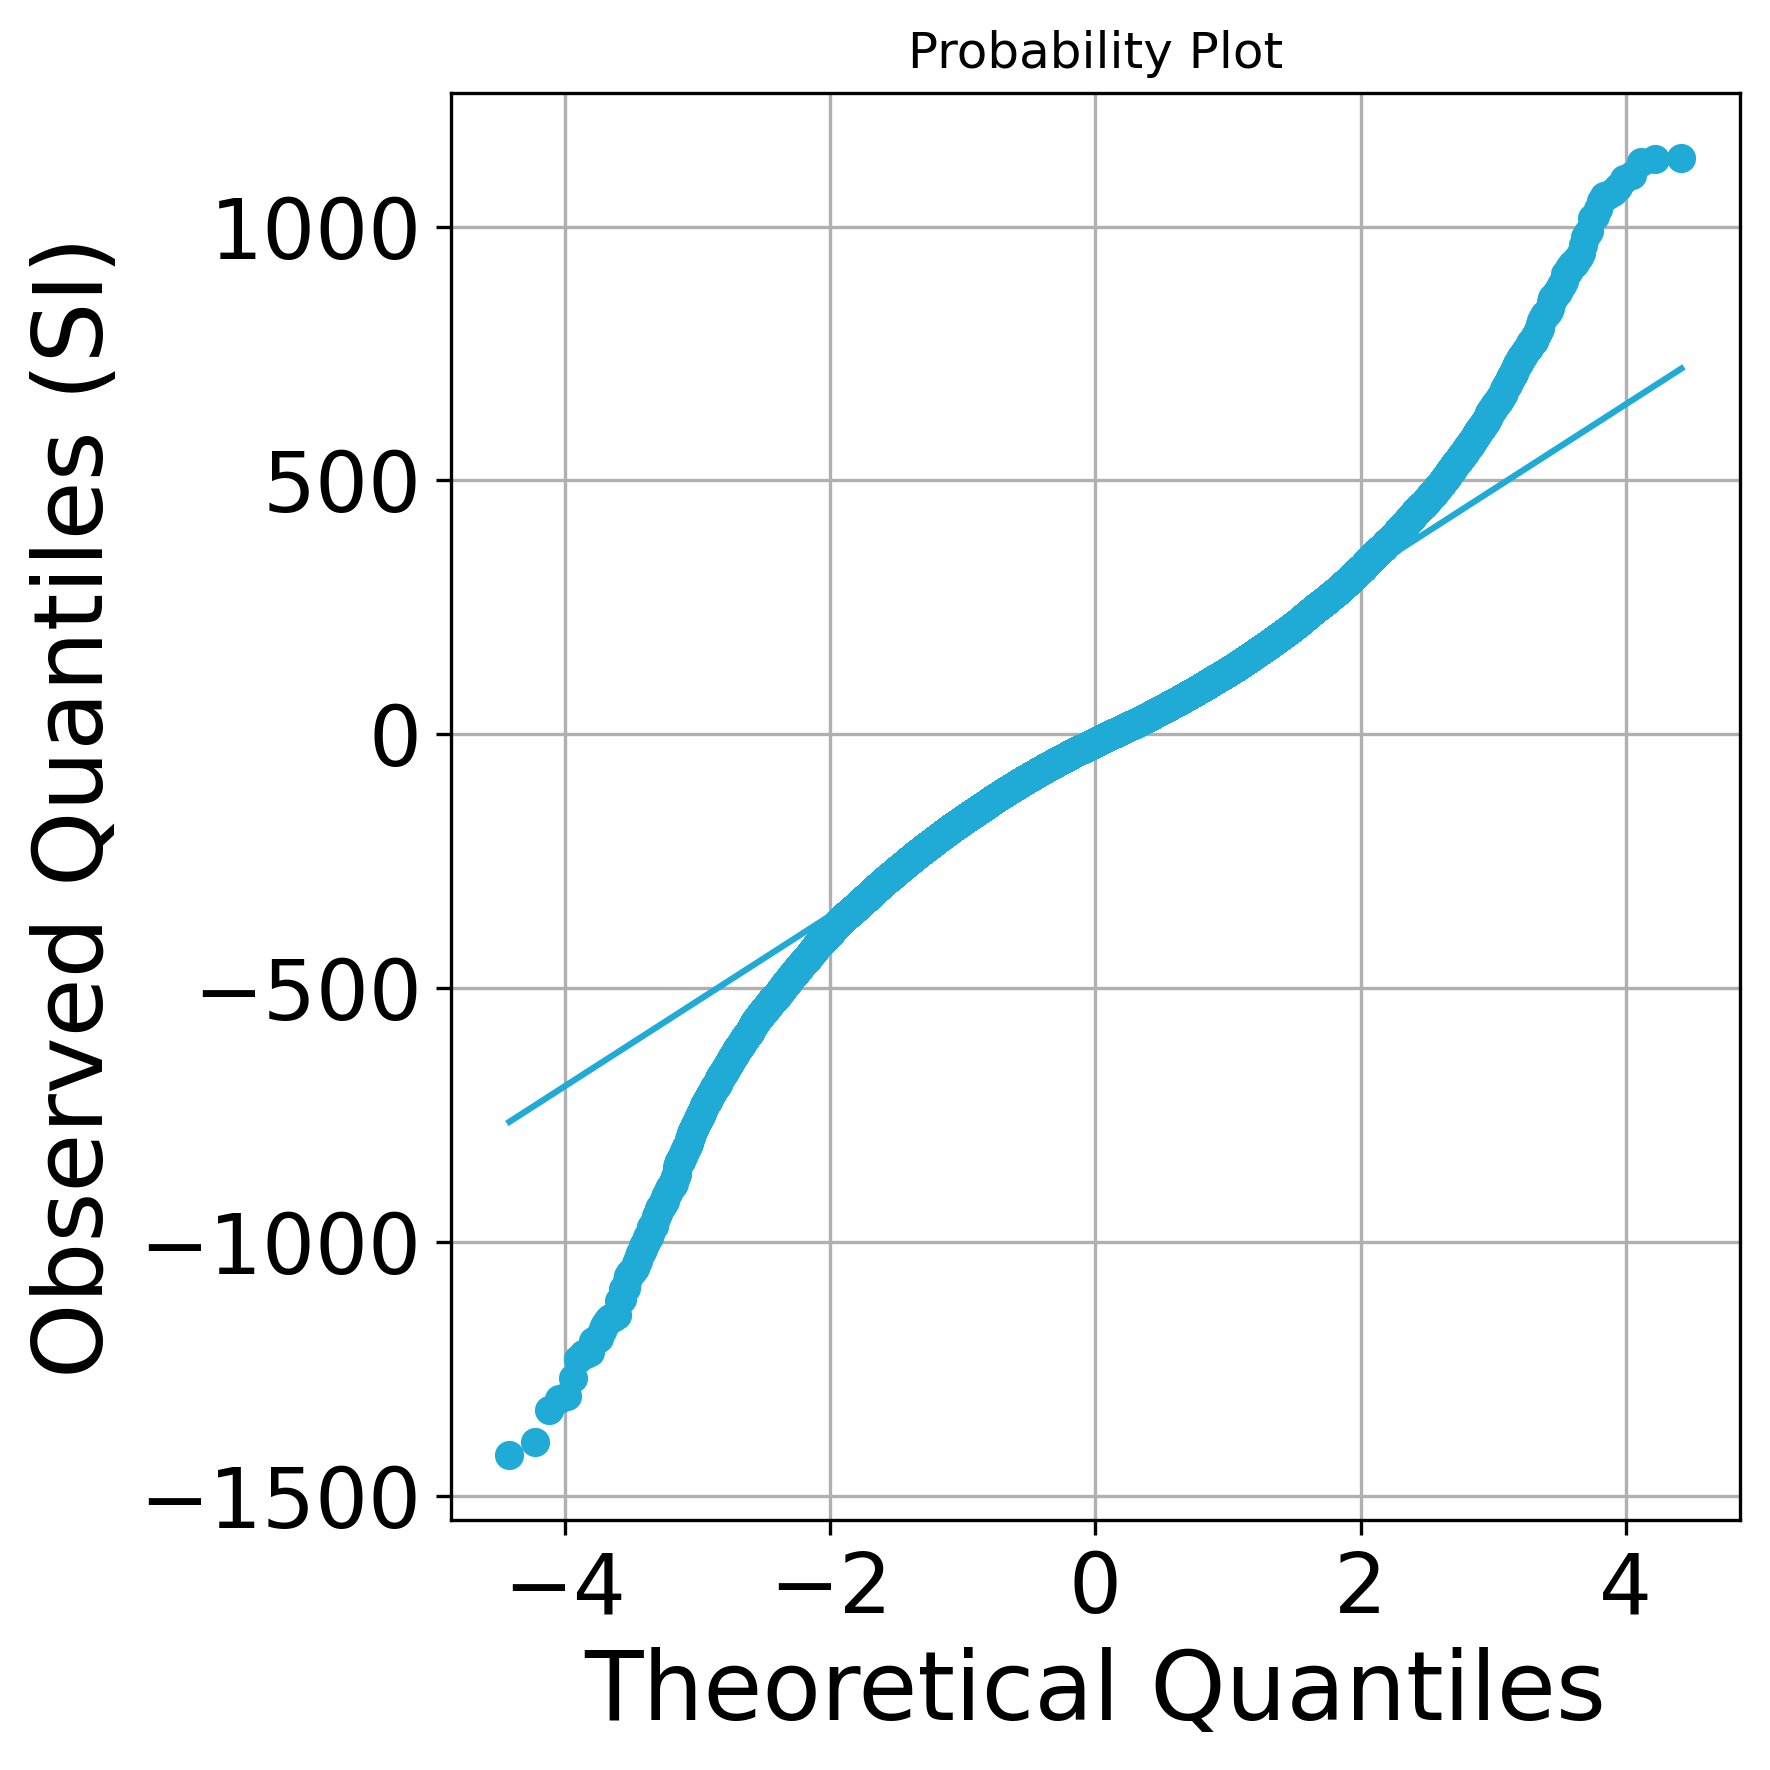

In [147]:
output = True
# Extract the signal (drop NaNs just in case)
data = qh['system_imbalance'].dropna()
import scipy.stats as stats

# Q-Q plot
fig2, ax = plt.subplots(figsize=(6, 6), dpi=300)

res = stats.probplot(data, dist="norm", plot=plt)
# plt.title("Q-Q Plot: System Imbalance vs Normal Distribution")
plt.xlabel("Theoretical Quantiles", fontsize=23)
plt.ylabel("Observed Quantiles (SI)", fontsize=23)
plt.grid(True)
ax.tick_params(axis='both', labelsize=20)
plt.style.use('default')
# Fix the color of the points and the line manually
ax = plt.gca()
for line in ax.get_lines():
    line.set_color(color)  # 'color' must be defined before

plt.tight_layout()
plt.show()
# Save if output is True
if output:
    fig2.savefig(f"/Users/jds/Desktop/fig2.png", dpi=300)

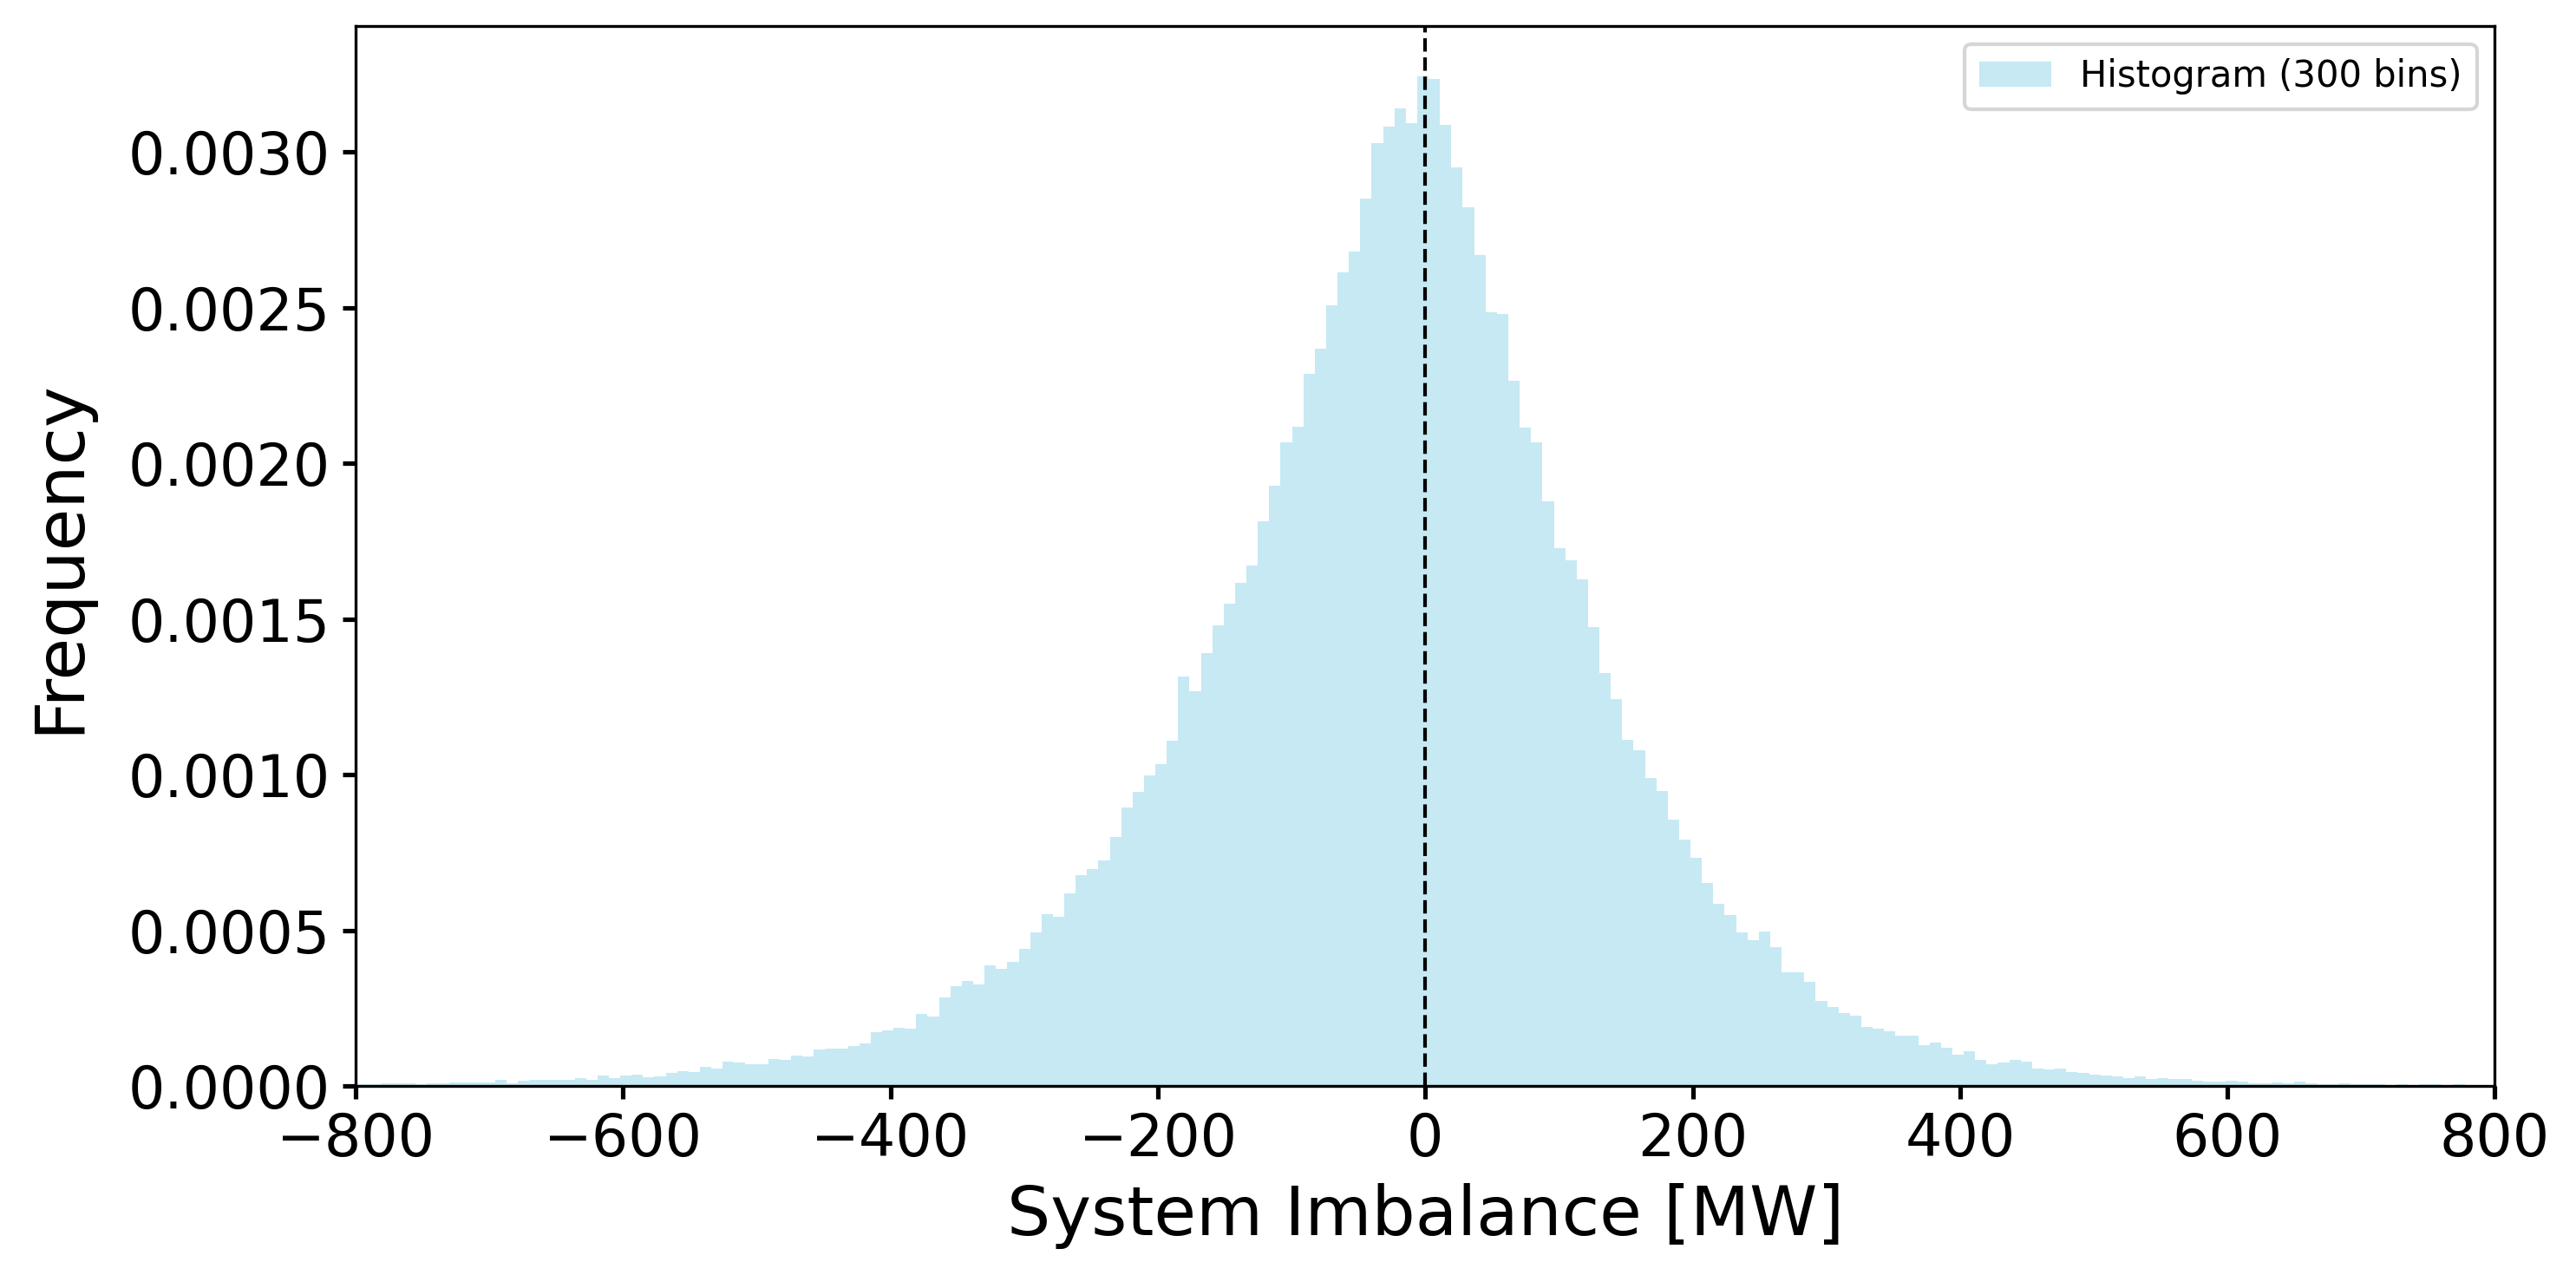

In [148]:
# Define plot styling variables (if not defined)
DPI = 300

# Extract the series and drop NaNs
si = qh["system_imbalance"].dropna()

# Number of bins
n_bins = 300
# Create figure and axis
fig3, ax = plt.subplots(figsize=(10, 5), dpi=DPI)
# Plot histogram over the same axis
si.plot(kind="hist", bins=n_bins, density=True, alpha=0.25,
        color=color, label=f"Histogram ({n_bins} bins)")
plt.xlim(-1500,1500)
# Annotate and format
# ax.set_title("System Imbalance Distribution")
ax.set_xlabel("System Imbalance [MW]", fontsize=19)
ax.axvline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlim(-800, 800)
ax.tick_params(width=1.25, labelsize=16)
ax.legend()
ax.set_ylabel("Frequency", fontsize=19, labelpad=10)

plt.tight_layout()
plt.show()
# Save if output is True
if output:
    fig3.savefig(f"/Users/jds/Desktop/fig3.png", dpi=300)


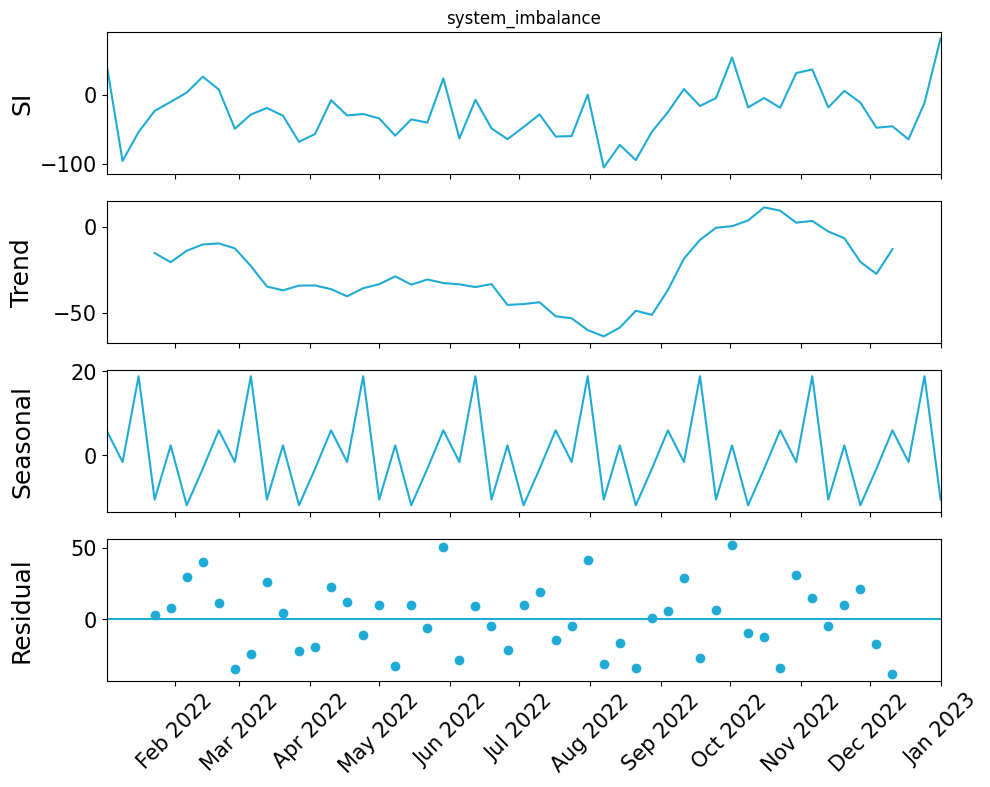

In [149]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

# Resample to weekly average
series = qh.loc["2022", "system_imbalance"].resample("W").mean().dropna()

# Decompose
decomposition = seasonal_decompose(series, model="additive", period=7)

# Plot
fig = decomposition.plot()
fig.set_size_inches(10, 8)
fig.suptitle("")  # Remove title (optional)

subplot_titles = ["SI", "Trend", "Seasonal", "Residual"]

# Customize styling
for i, ax in enumerate(fig.axes):
    # Set y-axis label
    ax.set_ylabel(subplot_titles[i], fontsize=18)

    # Set line colors
    for line in ax.get_lines():
        line.set_color(color)

    # Format dates on x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.tick_params(axis='x', labelsize=15, rotation=45)
    ax.tick_params(axis='y', labelsize=15)

plt.tight_layout()
fig.align_ylabels(fig.axes)  # <-- Align y-axis labels nicely
plt.subplots_adjust(top=0.95)
plt.show()


# Save if output is True
if output:
    fig.savefig("/Users/jds/Desktop/fig4.png", dpi=300)


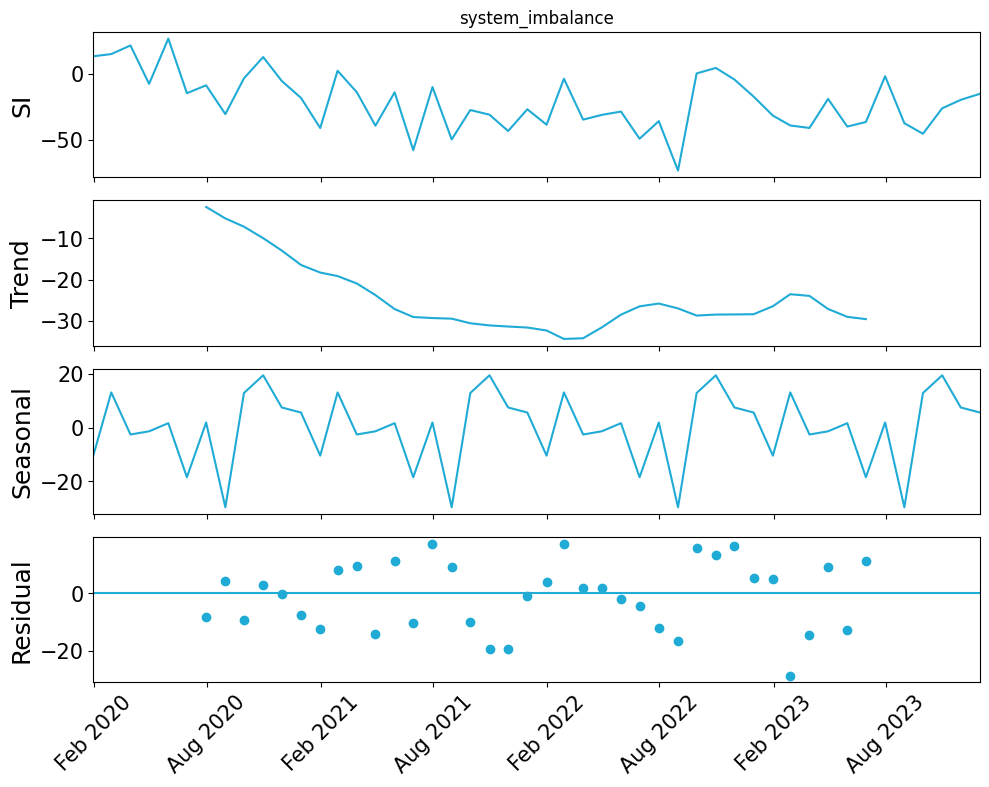

In [150]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

# Resample to monthly-end average
series = qh["system_imbalance"].resample("ME").mean().dropna()

# Decompose with 12-month seasonal period
decomposition = seasonal_decompose(series, model="additive", period=12)

# Plot
fig = decomposition.plot()
fig.set_size_inches(10, 8)
fig.suptitle("")  # Remove default title

subplot_titles = ["SI", "Trend", "Seasonal", "Residual"]

# Customize each subplot
for i, ax in enumerate(fig.axes):
    # Y-axis label
    ax.set_ylabel(subplot_titles[i], fontsize=18)

    # Line color
    for line in ax.get_lines():
        line.set_color(color)

    # Format x-axis date ticks
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.tick_params(axis='x', labelsize=15, rotation=45)
    ax.tick_params(axis='y', labelsize=15)

# Layout adjustments
plt.tight_layout()
fig.align_ylabels(fig.axes)
plt.subplots_adjust(top=0.95)
plt.show()

# Save if output is True
if output:
    fig.savefig("/Users/jds/Desktop/fig5.png", dpi=300)


Volume over time

In [151]:
def calculate_imbalance_volume(group, how="sum"):
    if how == "sum":
        return group.abs().sum()*0.25*1e-3  # To obtain GWh (multiply by 1/4 h)
    elif how=="mean":
        return group.abs().mean() # To obtain average MW

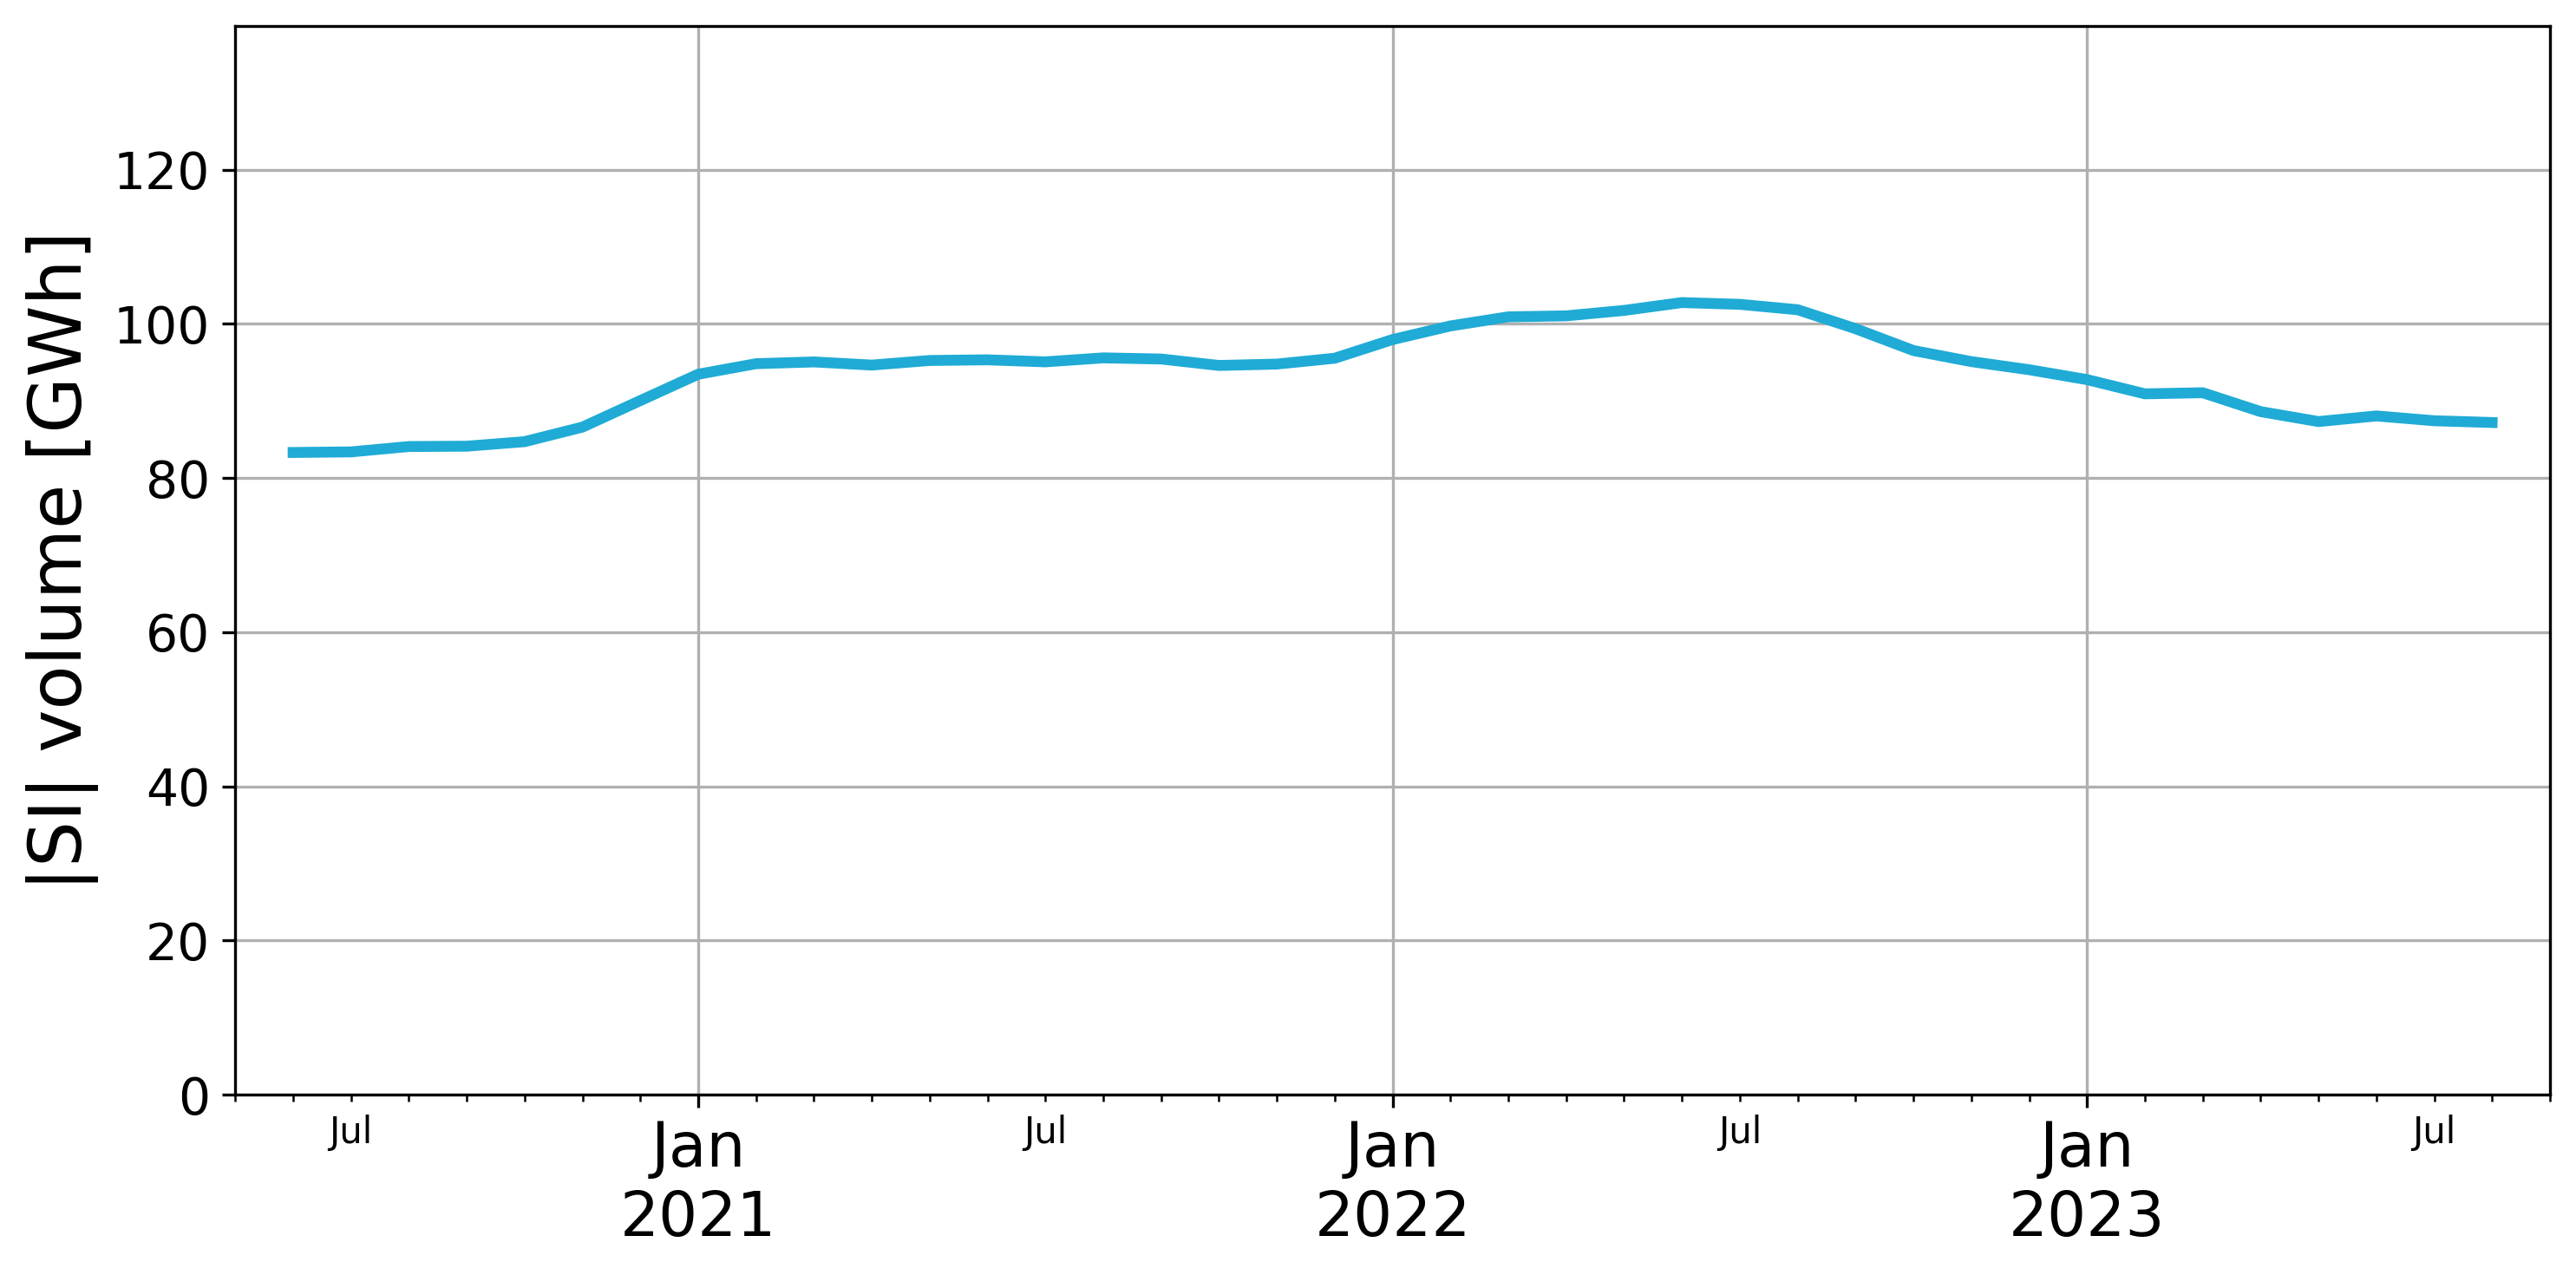

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Parameters
rolling_window = 10
DPI = 300
color = color  # Define your color

# Step 1: Ensure datetime index
qh = qh.copy()
qh.index = pd.to_datetime(qh.index)


# Step 2: Group by month using resample
monthly_si = qh["system_imbalance"].resample("MS").apply(lambda x: calculate_imbalance_volume(x, how="sum"))

# Step 3: Apply rolling average
rolling_series = monthly_si.rolling(rolling_window, center=True).mean()

# Step 4: Plot
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)

rolling_series.plot(
    ax=ax,
    color=color,
    linewidth=3,
    ylabel="|SI| volume [GWh]",
    xlabel=""
)

# Format x-axis
ax.set_xlim(pd.to_datetime("2020-05-01"), pd.to_datetime("2023-9-01"))
ax.set_ylim(0, 1.25 * monthly_si.max())
ax.set_ylabel("|SI| volume [GWh]", fontsize= 20)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=17)
ax.grid(True)
plt.tight_layout()
plt.show()

# Optional: Save
if output:
    fig.savefig("/Users/jds/Desktop/fig6.png", dpi=300)


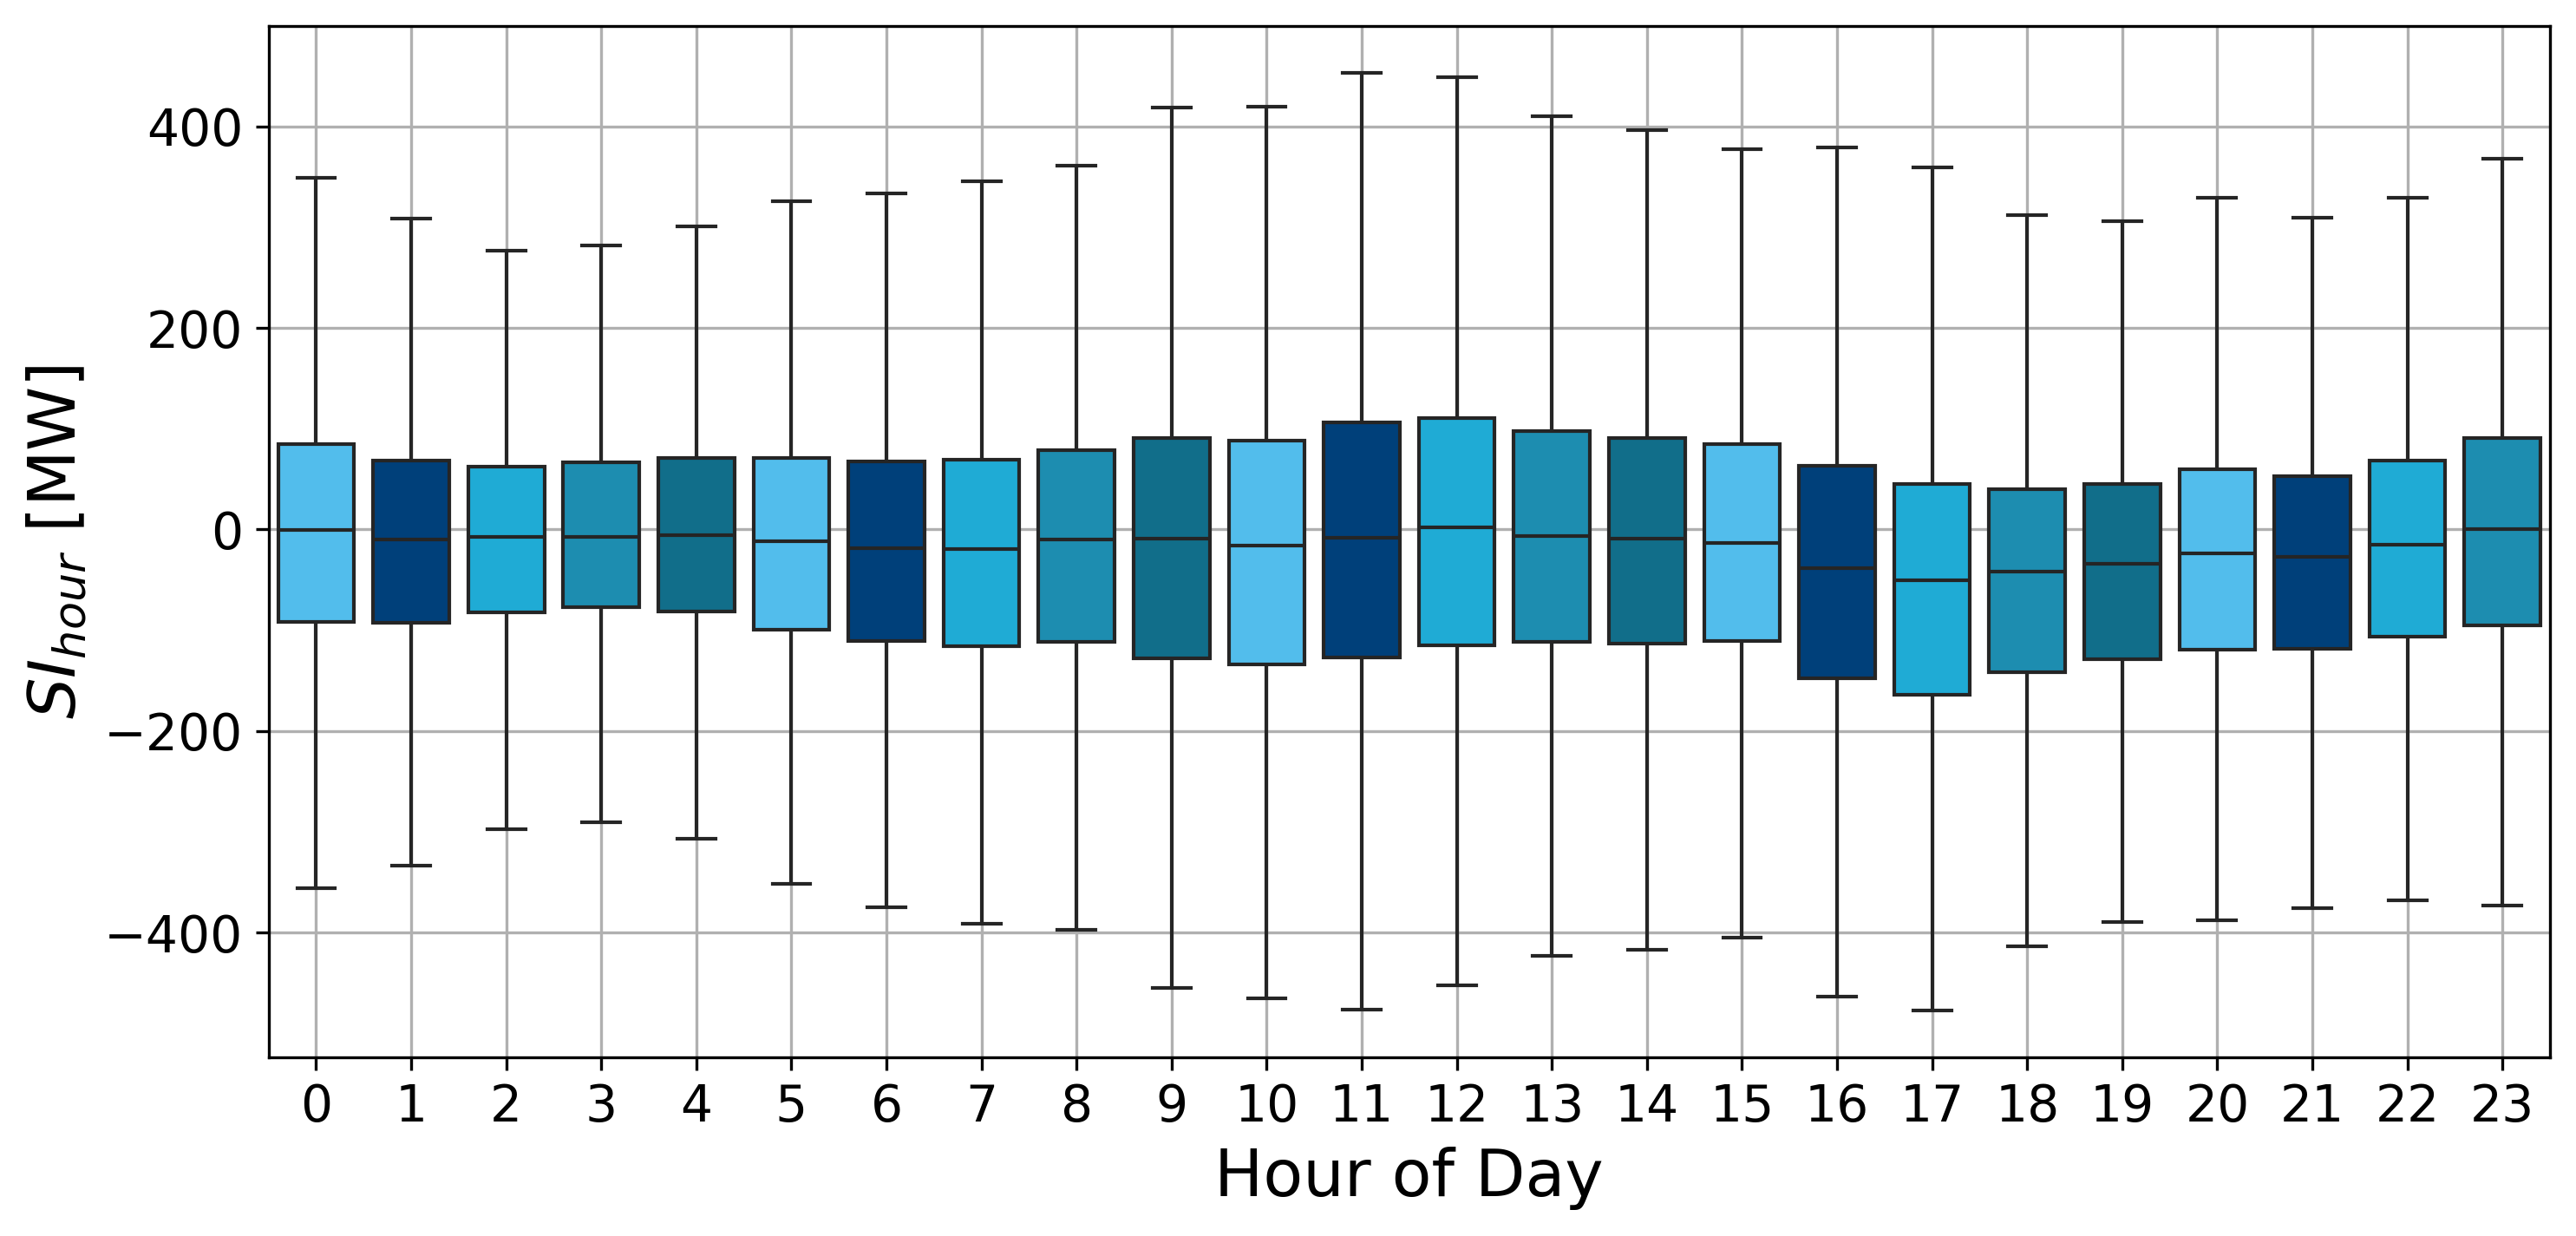

In [153]:
import seaborn as sns

# Step 1: Ensure datetime index
qh.index = pd.to_datetime(qh.index)

# Step 2: Create a column for the hour of day
qh_all = qh.copy()
qh_all['hour'] = qh_all.index.hour

colors = [
    "#52BDEC",  # Light Blue (Logo)
    "#00407A",  # Dark Blue (Logo)
    "#1FABD5",  # Bright Cyan (Grid)
    "#1D8DB0",  # Muted Teal (Grid)
    "#116E8A"   # Dark Teal (Grid)
]

# Repeat or truncate to match number of x-ticks (e.g., 24 hours)
palette = colors * (24 // len(colors) + 1)
palette = palette[:24]  # Now exactly 24 colors

# Step 3: Plot boxplots grouped by hour
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sns.boxplot(data=qh_all, x='hour', y='system_imbalance',hue ='hour', showfliers=False, ax=ax,palette=palette,    legend=False, saturation=1 )


# Step 4: Formatting
ax.set_xlabel('Hour of Day', fontsize=18)
ax.set_ylabel('$SI_{hour}$ [MW]', fontsize=18)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
# ax.set_ylim(-200, 200)  # Adjust range as appropriate
plt.suptitle('')  # Remove default pandas suptitle
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Save if needed
if output:
    fig.savefig("/Users/jds/Desktop/fig7.png", dpi=300)


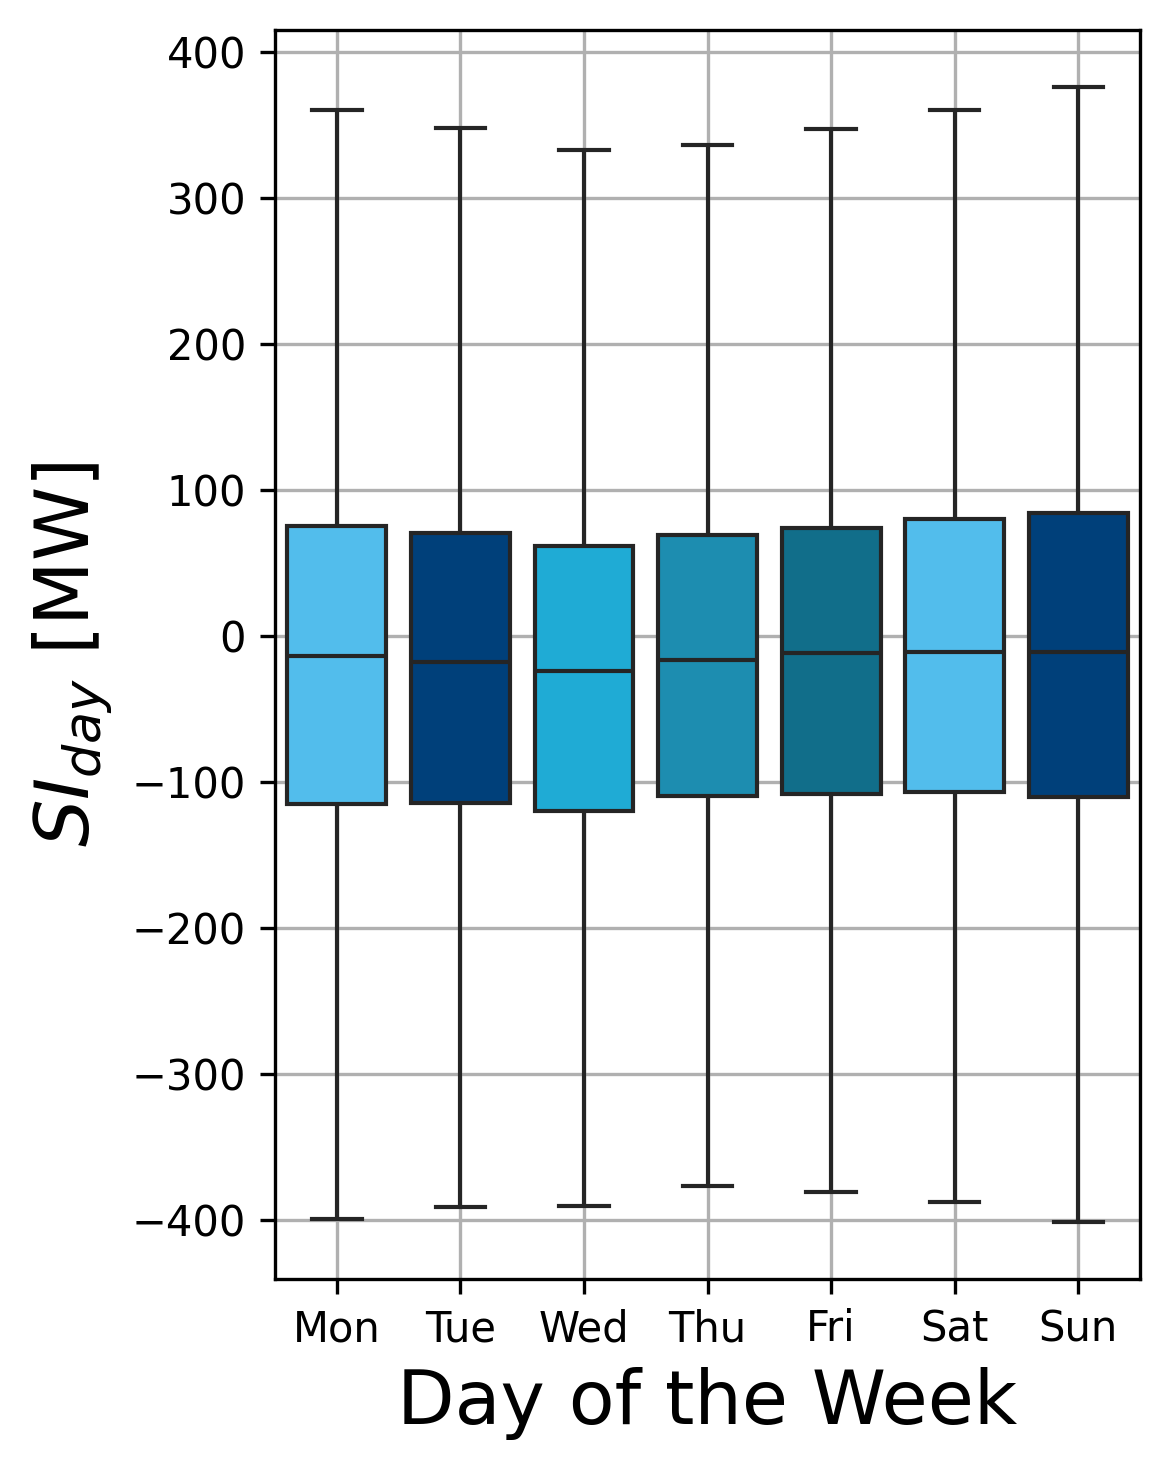

In [154]:

# Ensure datetime index
qh.index = pd.to_datetime(qh.index)
qh['weekday'] = qh.index.strftime('%a')  # Abbreviated day names

# Sort abbreviations correctly
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
qh['weekday'] = pd.Categorical(qh['weekday'], categories=weekday_order, ordered=True)

# Set up figure and colors
fig, ax = plt.subplots(figsize=(4, 5), dpi=300)
colors = ["#52BDEC", "#00407A", "#1FABD5", "#1D8DB0", "#116E8A"]
palette = colors * (7 // len(colors) + 1)
palette = palette[:7]

# Boxplot
sns.boxplot(
    data=qh,
    x='weekday',
    y='system_imbalance',
    hue='weekday',
    showfliers=False,
    ax=ax,
    palette=palette,
    saturation=1,
    legend=False
)

# Formatting
ax.set_xlabel('Day of the Week', fontsize=18)
ax.set_ylabel('$SI_{day}$ [MW]', fontsize=18)
ax.grid(True)
plt.tight_layout()

# Save
if output:
    fig.savefig("/Users/jds/Desktop/fig8.png", dpi=300)

plt.show()


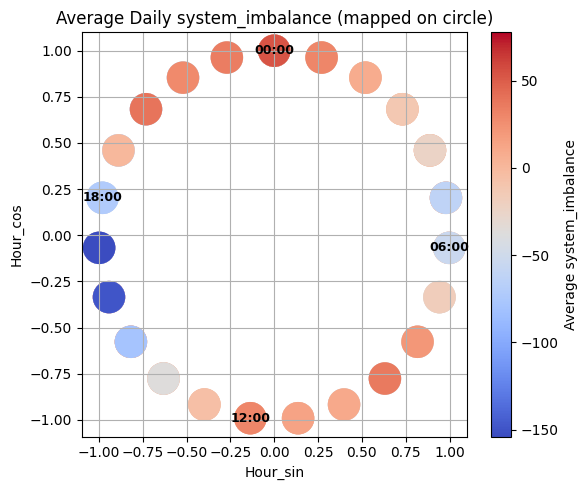

In [155]:
    qh.index = pd.to_datetime(qh.index)
    target = target_qh
    df = qh.copy()
    # Extract time of day index (0–95) for quarter-hours
    df['qh_index'] = df.index.hour * 4 + df.index.minute // 15

    # Compute Hour_sin / Hour_cos if not already present
    if 'Hour_sin' not in df.columns or 'Hour_cos' not in df.columns:
        df['Hour_sin'] = np.sin(2 * np.pi * df['qh_index'] / 96)
        df['Hour_cos'] = np.cos(2 * np.pi * df['qh_index'] / 96)

    # Group by time of day (0–95) and compute average target
    avg = df.groupby('qh_index')[[target, 'Hour_sin', 'Hour_cos']].mean()

    # Plot
    plt.figure(figsize=(6, 5))
    sc = plt.scatter(avg['Hour_sin'], avg['Hour_cos'], c=avg[target],
                     cmap='coolwarm', s=500)

    for i in [0, 24, 48, 72]:  # annotate a few key hours
        hour = i // 4
        plt.text(avg['Hour_sin'].iloc[i], avg['Hour_cos'].iloc[i], f"{hour:02d}:00",
                 fontsize=9, ha='center', va='center', weight='bold')

    plt.colorbar(sc, label=f'Average {target}')
    plt.title(f'Average Daily {target} (mapped on circle)')
    plt.xlabel('Hour_sin')
    plt.ylabel('Hour_cos')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Autocorrelation

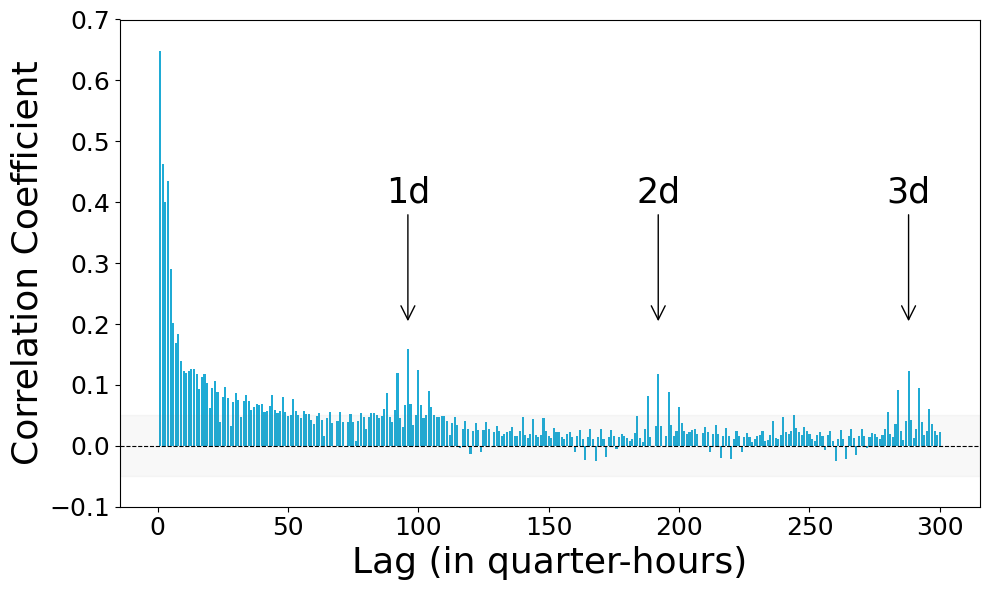

In [156]:
# --- Parameters ---
num_lags = 300
target_column = 'system_imbalance'

# --- Create lagged features from your real data ---
qh_all = qh.copy()
X = pd.concat([qh_all[target_column].shift(i).rename(f'{target_column}_lag_{i}')
               for i in range(1, num_lags + 1)], axis=1)
X.dropna(inplace=True)
y = qh_all.loc[X.index, target_column]

# --- Compute autocorrelations ---
autocorrelations = {
    lag: np.corrcoef(X[f'{target_column}_lag_{lag}'], y)[0, 1]
    for lag in range(1, num_lags + 1)
}

# --- Plot ---
fig = plt.figure(figsize=(10, 6))
plt.bar(autocorrelations.keys(), autocorrelations.values(), color=color)
plt.xlabel('Lag (in quarter-hours)', fontsize=26)
plt.ylabel('Correlation Coefficient', fontsize=26)
plt.ylim(-0.1, 0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axhspan(-0.05, 0.05, color='grey', alpha=0.05, label='~Uncorrelated zone')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# Highlight key lags (daily periodicity: 96 QH = 1 day)
highlight_lags = [96, 192, 288, 384]
for lag in highlight_lags:
    if lag <= num_lags:
        plt.annotate(text=f'{lag // 96}d',xy=(lag, 0.2),xytext=(lag, 0.4), ha='center',fontsize=25,color="black",arrowprops=dict(arrowstyle='->',color="black",lw=1)        )


plt.tight_layout()
plt.show()
# Save
if output:
    fig.savefig("/Users/jds/Desktop/fig10.png", dpi=300)


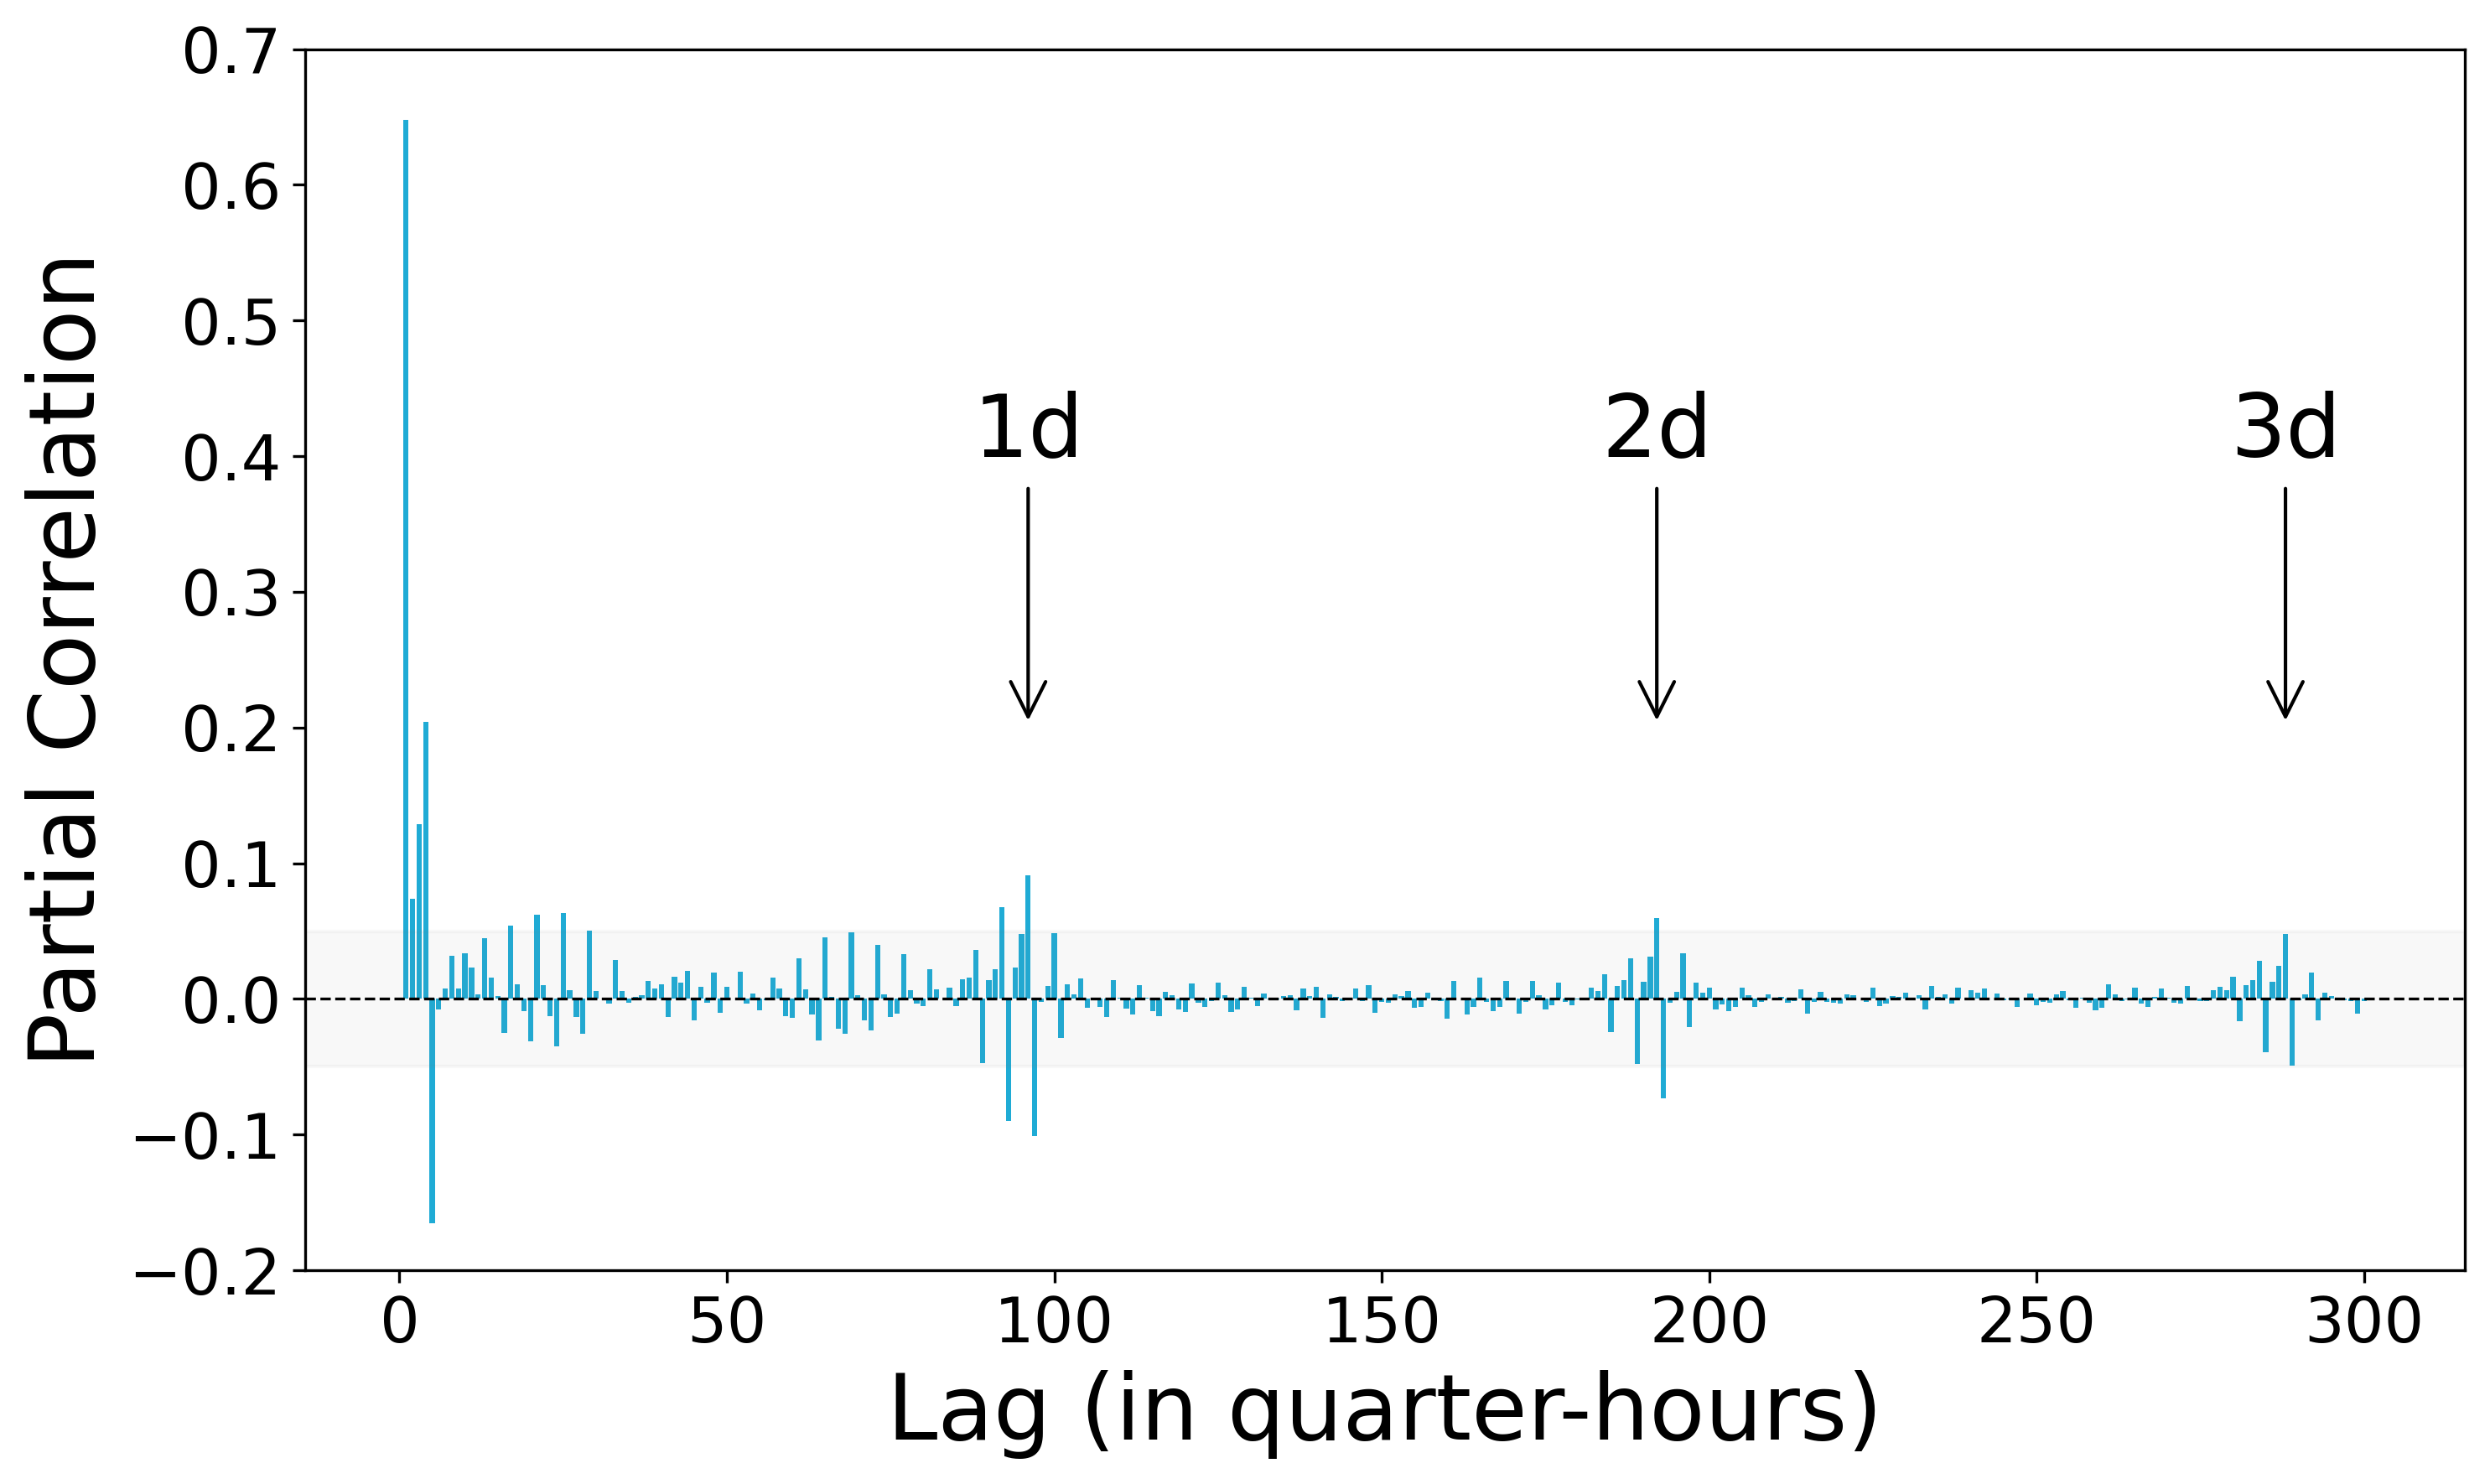

In [157]:
from statsmodels.graphics.tsaplots import plot_pacf

series = qh['system_imbalance']

# --- Define number of lags ---
num_lags = 300

# --- Create PACF plot ---
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
pacf_vals = pacf(series, nlags=num_lags, method='ywm')[1:]  # skip lag 0
lags = np.arange(1, num_lags + 1)
plt.bar(lags, pacf_vals, color=color)

for line in ax.lines:
    if line.get_marker() not in [None, '', 'None']:
        line.set_marker('')
# Hide the first stem (lag 0, which is always 1.0)

ax.set_xlabel('Lag (in quarter-hours)', fontsize=26)
ax.set_ylabel('Partial Correlation', fontsize=26)
ax.axhspan(-0.05, 0.05, color='grey', alpha=0.05)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.ylim(-0.2, 0.7)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Highlight key lags (daily periodicity: 96 QH = 1 day)
highlight_lags = [96, 192, 288, 384]
for lag in highlight_lags:
    if lag <= num_lags:
        plt.annotate(text=f'{lag // 96}d',xy=(lag, 0.2),xytext=(lag, 0.4), ha='center',fontsize=25,color="black",arrowprops=dict(arrowstyle='->',color="black",lw=1)        )
plt.tight_layout()
plt.show()
# Save
if output:
    fig.savefig("/Users/jds/Desktop/fig11.png", dpi=300)

In [158]:
# --- Get top N lags based on absolute PACF value ---
top_n = 60  # or set your own threshold
threshold = None  # alternatively, set e.g., 0.1
num_lags = 1000

# Compute PACF values (skip lag 0)
pacf_vals = pacf(series, nlags=num_lags, method='ywm')[1:]
lags = np.arange(1, num_lags + 1)
lag_values = list(zip(lags, pacf_vals))

# Sort by absolute PACF value
lag_values_sorted = sorted(lag_values, key=lambda x: abs(x[1]), reverse=True)

# Apply threshold or top-N
if threshold is not None:
    significant_lags = [(lag, val) for lag, val in lag_values if abs(val) > threshold]
    print(f"\nNumber of lags with |PACF| > {threshold}: {len(significant_lags)}")
else:
    significant_lags = lag_values_sorted[:top_n]

# Output ranked by |PACF| value
print("\nTop significant lags (by |PACF|):")
for lag, val in significant_lags:
    print(f"Lag {lag}: PACF = {val:.4f}")

# Also output same list ordered by lag
significant_lags_sorted_by_lag = sorted(significant_lags, key=lambda x: x[0])

print("\nTop significant lags (ordered by lag):")
for lag, val in significant_lags_sorted_by_lag:
    print(f"Lag {lag}: PACF = {val:.4f}")
print("\nTop significant lags (ordered by lag):")
for lag, val in significant_lags_sorted_by_lag:
    print(f"{lag},")



Top significant lags (by |PACF|):
Lag 1: PACF = 0.6478
Lag 4: PACF = 0.2044
Lag 5: PACF = -0.1655
Lag 3: PACF = 0.1289
Lag 97: PACF = -0.1009
Lag 96: PACF = 0.0913
Lag 93: PACF = -0.0900
Lag 2: PACF = 0.0741
Lag 193: PACF = -0.0731
Lag 92: PACF = 0.0674
Lag 25: PACF = 0.0635
Lag 21: PACF = 0.0621
Lag 192: PACF = 0.0597
Lag 17: PACF = 0.0539
Lag 29: PACF = 0.0506
Lag 69: PACF = 0.0493
Lag 289: PACF = -0.0490
Lag 100: PACF = 0.0482
Lag 95: PACF = 0.0481
Lag 189: PACF = -0.0479
Lag 288: PACF = 0.0476
Lag 89: PACF = -0.0474
Lag 65: PACF = 0.0453
Lag 13: PACF = 0.0450
Lag 385: PACF = -0.0438
Lag 481: PACF = -0.0426
Lag 673: PACF = -0.0418
Lag 384: PACF = 0.0399
Lag 73: PACF = 0.0395
Lag 285: PACF = -0.0390
Lag 577: PACF = -0.0390
Lag 480: PACF = 0.0365
Lag 88: PACF = 0.0362
Lag 24: PACF = -0.0350
Lag 576: PACF = 0.0344
Lag 381: PACF = -0.0344
Lag 769: PACF = -0.0341
Lag 672: PACF = 0.0339
Lag 196: PACF = 0.0336
Lag 10: PACF = 0.0334
Lag 77: PACF = 0.0332
Lag 8: PACF = 0.0318
Lag 191: PACF 

Mutual information

In [159]:
from sklearn.feature_selection import mutual_info_regression

num_lags = 300
target_column = 'system_imbalance'

# --- Create lagged features ---
qh_all = qh.copy()
X = pd.concat([qh_all[target_column].shift(i).rename(f'{target_column}_lag_{i}')
               for i in range(1, num_lags + 1)], axis=1)
X.dropna(inplace=True)
y = qh_all.loc[X.index, target_column]

# --- Compute Mutual Information (nonlinear dependency measure) ---
from sklearn.preprocessing import StandardScaler

# MI expects numeric input without NaNs
mi_scores = mutual_info_regression(X, y, random_state=42)

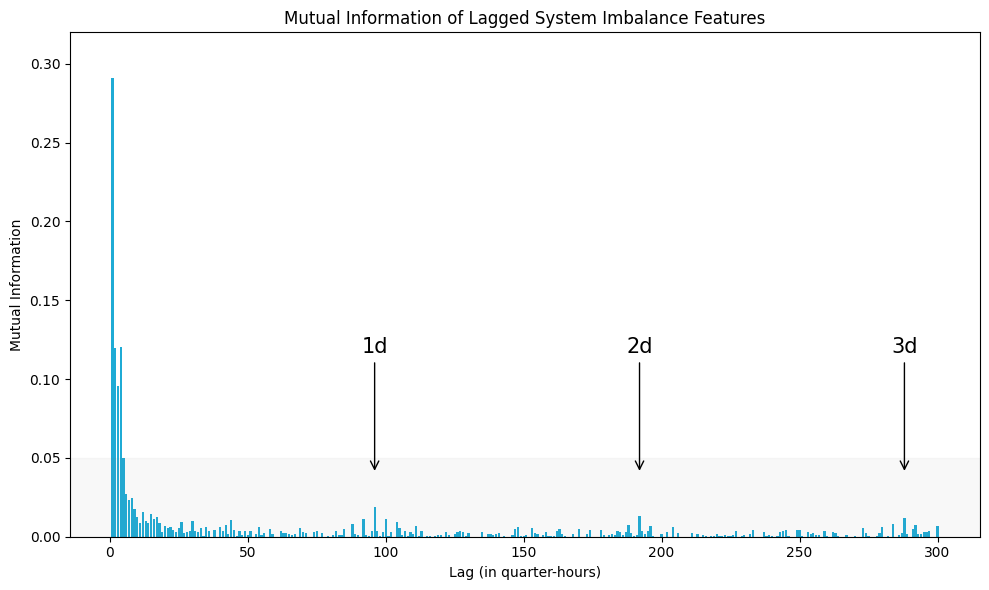

In [160]:
# --- Plot ---
num_lags = 300
fig = plt.figure(figsize=(10, 6))
plt.bar(range(1, num_lags + 1), mi_scores, color=color)
plt.xlabel('Lag (in quarter-hours)')
plt.ylabel('Mutual Information')
plt.ylim(0, max(mi_scores) * 1.1)
plt.title('Mutual Information of Lagged System Imbalance Features', fontsize=12)

# Optional: Visual aid for "small values"
plt.axhspan(0, 0.05, color='grey', alpha=0.05, label='~Low MI zone')

# Highlight key lags (daily periodicity: 96 QH = 1 day)
highlight_lags = [96, 192, 288, 384]
for lag in highlight_lags:
    if lag <= num_lags:
        plt.annotate(text=f'{lag // 96}d',
                     xy=(lag, 0.04),
                     xytext=(lag, max(mi_scores) * 0.4),
                     ha='center',
                     fontsize=15,
                     color="black",
                     arrowprops=dict(arrowstyle='->', color="black", lw=1)
                     )

plt.tight_layout()
plt.show()

# --- Save ---
if output:
    fig.savefig("/Users/jds/Desktop/fig12.png", dpi=300)


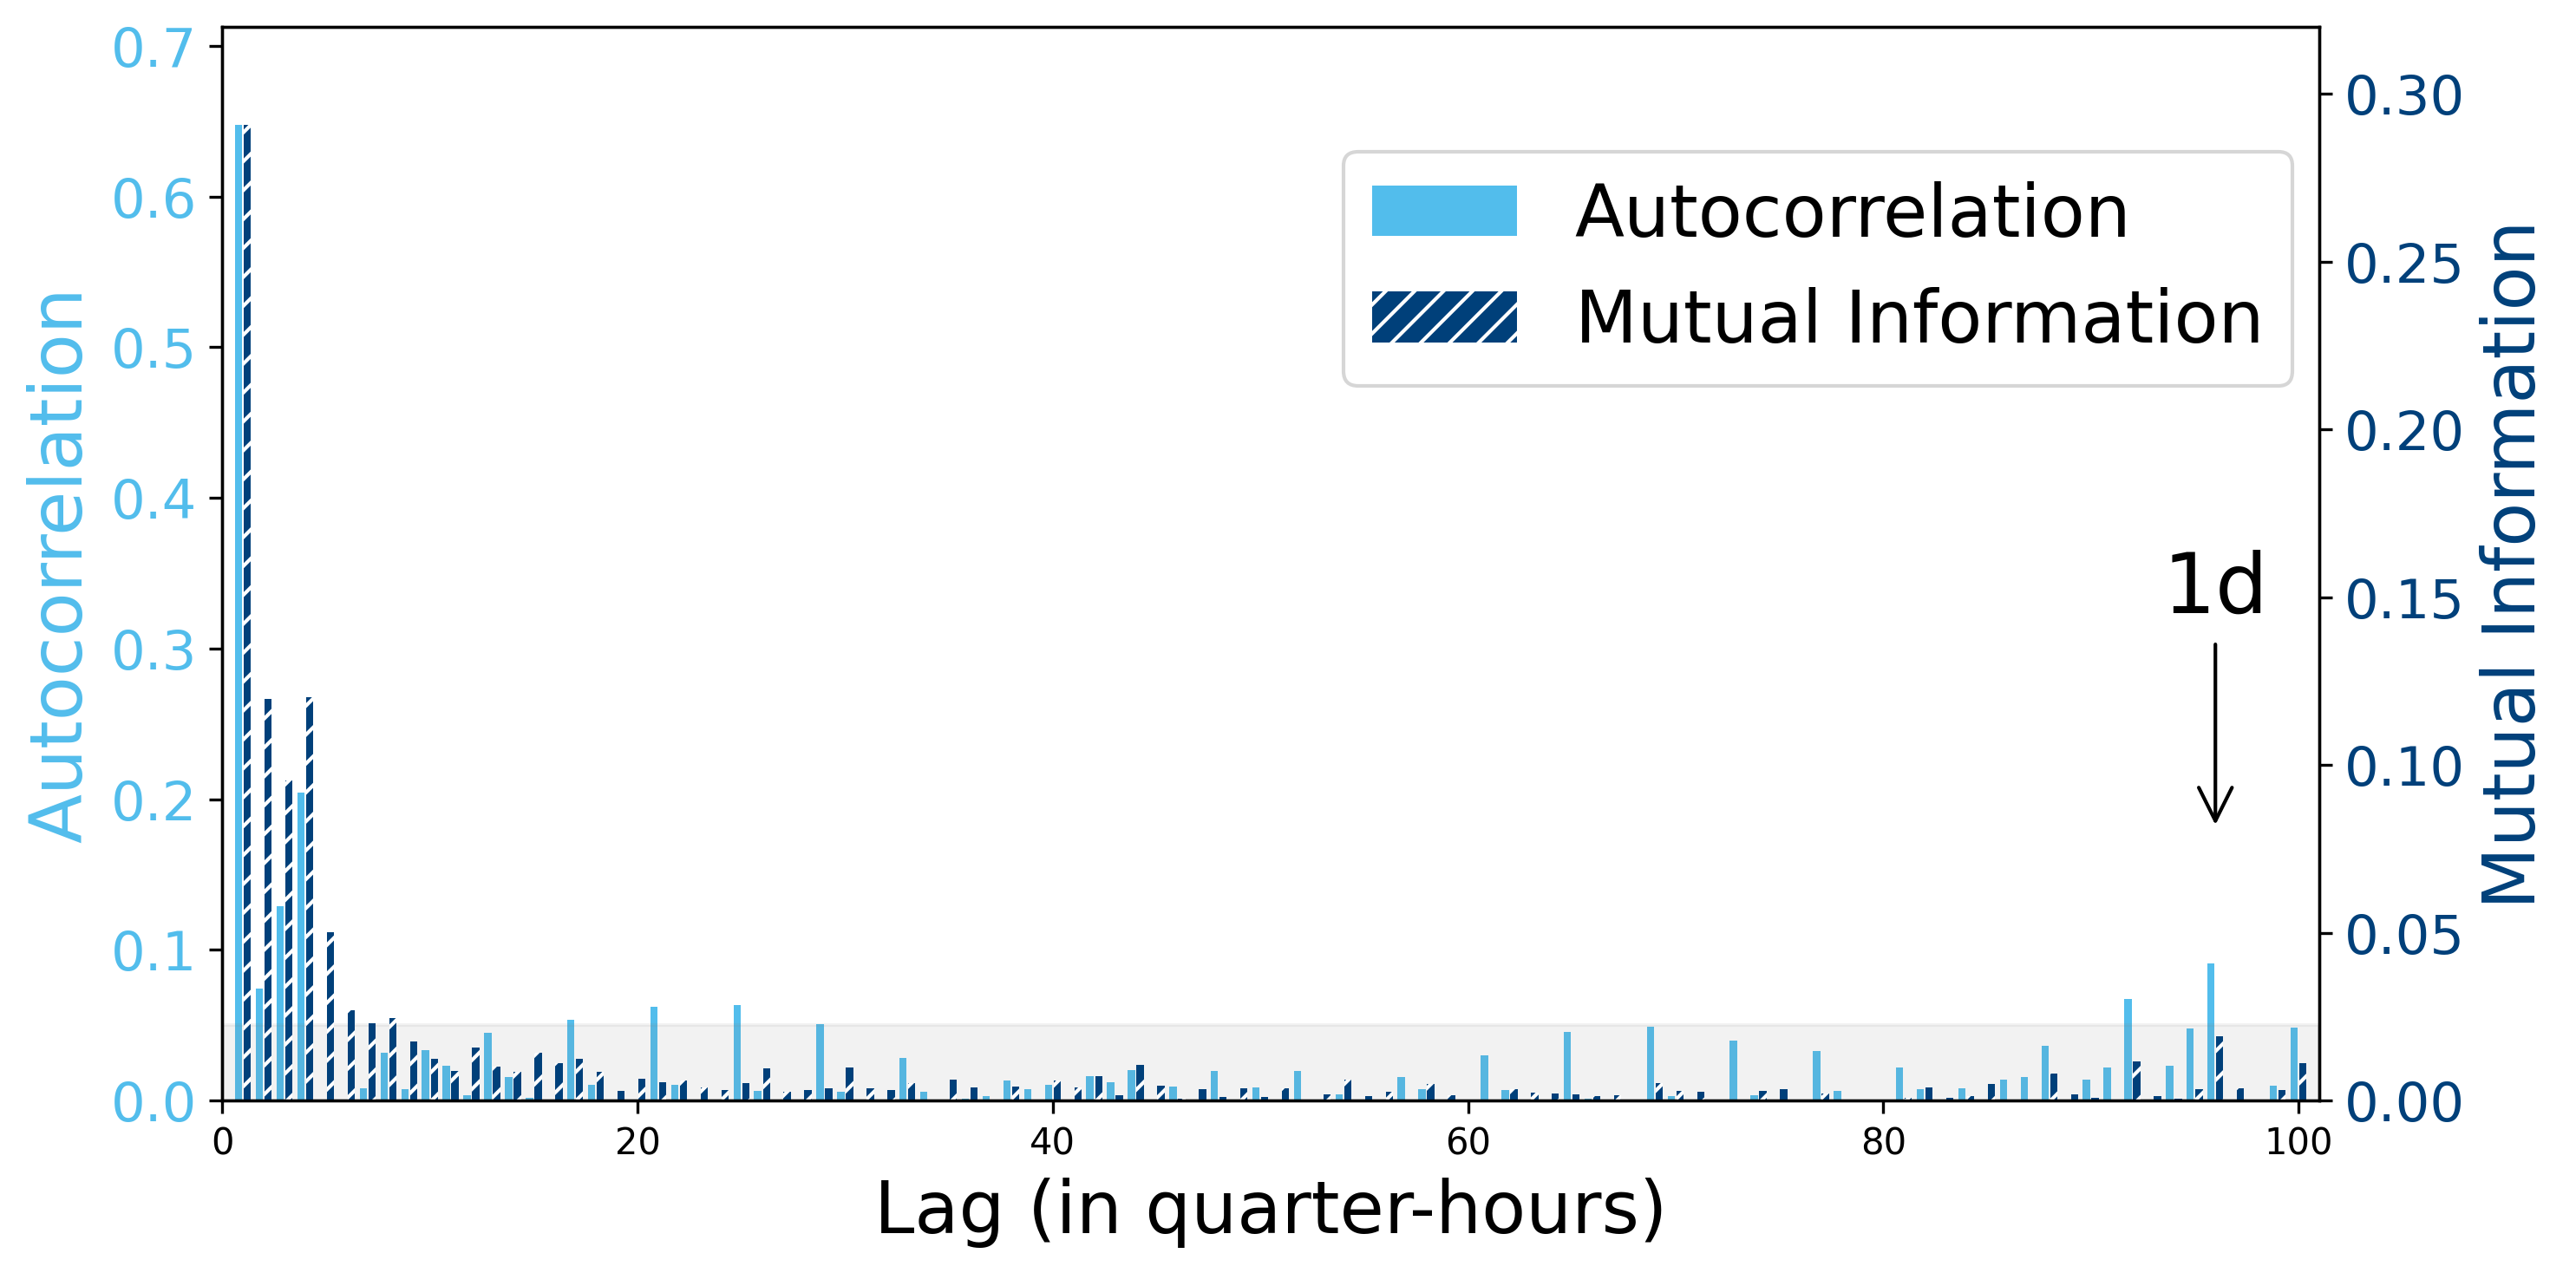

In [162]:
output = True
# --- Parameters ---
num_lags = 100
lags = np.arange(1, num_lags + 1)

# --- Compute Pearson and Mutual Information (if not already computed) ---
pearson_scores = [np.corrcoef(X[f'{target_column}_lag_{lag}'], y)[0, 1] for lag in lags]
# Assume `mi_scores` is already computed using mutual_info_regression

# --- Plot setup ---
fig, ax1 = plt.subplots(figsize=(10, 5), dpi=300)
width = 0.35         # narrower bars
spacing = 1.2       # more horizontal space between groups
# Set global hatch color
plt.rcParams['hatch.color'] = 'white'
# --- Pearson bars (left axis) ---
bars1 = ax1.bar(
    lags - width * spacing / 2,
    pacf_vals[:num_lags],
    width=width,
    color='#52BDEC',
    label='PACF'
)
ax1.set_ylabel('Autocorrelation', color="#52BDEC", fontsize=20)
ax1.set_xlabel('Lag (in quarter-hours)', fontsize=20)
ax1.tick_params(axis='y', labelcolor='#52BDEC', labelsize=15)
ax1.axhspan(-0.05, 0.05, color='grey', alpha=0.1)
ax1.set_ylim(0, max(pearson_scores[:num_lags]) * 1.1)

# --- Mutual Information bars (right axis) ---
ax2 = ax1.twinx()
bars2 = ax2.bar(
    lags + width * spacing / 2,
    mi_scores[:num_lags],
    width=width,
    color="#00407A",
    hatch='///',
    label='Mutual Information'
)
ax2.set_ylabel('Mutual Information', color="#00407A", fontsize=20)
ax2.tick_params(axis='y', labelcolor="#00407A", labelsize=15)
ax2.set_ylim(0, max(mi_scores[:num_lags]) * 1.1)
ax2.set_xlim(0, num_lags + 1)
# Highlight key lags (daily periodicity: 96 QH = 1 day)
highlight_lags = [96, 192, 288, 384]
for lag in highlight_lags:
    if lag <= num_lags:
        plt.annotate(text=f'{lag // 96}d',
                     xy=(lag, 0.08),
                     xytext=(lag, max(mi_scores) * 0.5),
                     ha='center',
                     fontsize=23,
                     color="black",
                     arrowprops=dict(arrowstyle='->', color="black", lw=1)
                     )
# --- Title and layout ---
fig.tight_layout()

# --- Combined legend ---
# Manually create legend handles from both axes
handles = [bars1[0], bars2[0]]
labels = ['Autocorrelation', 'Mutual Information']
fig.legend(
    handles,
    labels,
    loc='upper right',           # Place it in the top-left of the axes area
    bbox_to_anchor=(0.90, 0.9), # Fine-tune position: (x, y) in axis fraction
    frameon=True,
    fontsize=20
)

plt.show()

# --- Save ---
if output:
    fig.savefig("/Users/jds/Desktop/fig13.png", dpi=300)


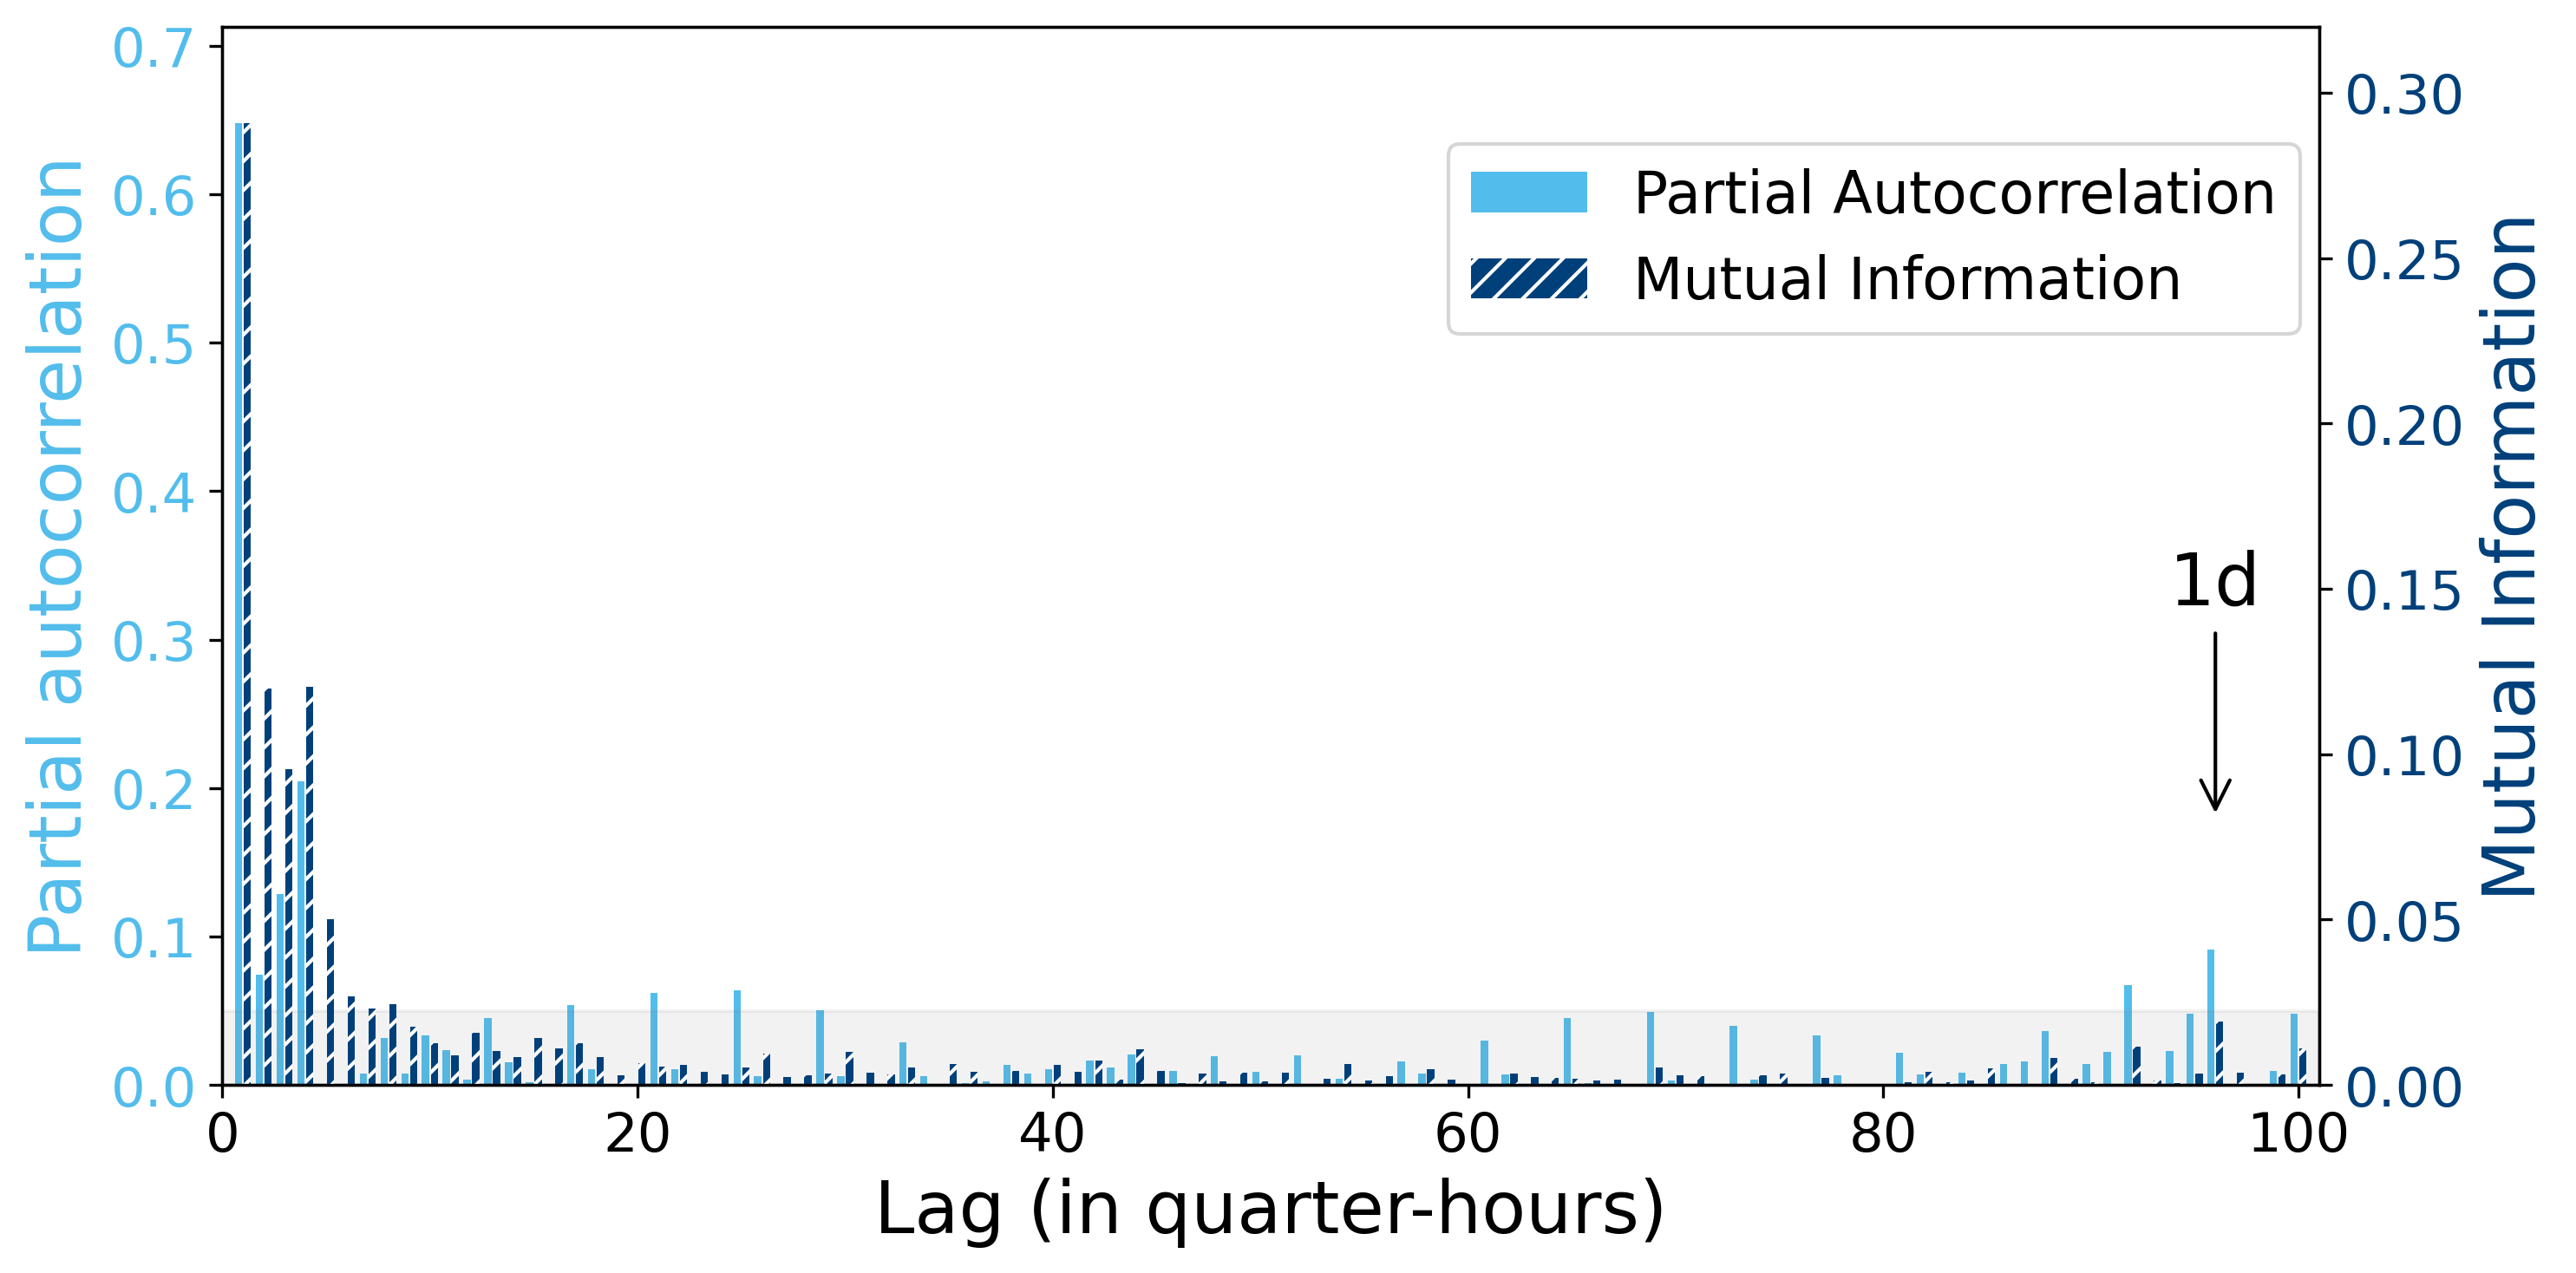

In [168]:
# --- Parameters ---
num_lags = 100
lags = np.arange(1, num_lags + 1)

# --- Compute Pearson and Mutual Information (if not already computed) ---
pearson_scores = [np.corrcoef(X[f'{target_column}_lag_{lag}'], y)[0, 1] for lag in lags]
# Assume `mi_scores` is already computed using mutual_info_regression

# --- Plot setup ---
fig, ax1 = plt.subplots(figsize=(10, 5), dpi=300)
width = 0.35         # narrower bars
spacing = 1.2       # more horizontal space between groups
# Set global hatch color
plt.rcParams['hatch.color'] = 'white'
# --- Pearson bars (left axis) ---
bars1 = ax1.bar(
    lags - width * spacing / 2,
    pacf_vals[:num_lags],
    width=width,
    color='#52BDEC',
    label='PACF'
)
ax1.set_ylabel('Partial autocorrelation', color="#52BDEC", fontsize=20)
ax1.set_xlabel('Lag (in quarter-hours)', fontsize=20)
ax1.tick_params(axis='y', labelcolor='#52BDEC', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)
ax1.axhspan(-0.05, 0.05, color='grey', alpha=0.1)
ax1.set_ylim(0, max(pacf_vals[:num_lags]) * 1.1)

# --- Mutual Information bars (right axis) ---
ax2 = ax1.twinx()
bars2 = ax2.bar(
    lags + width * spacing / 2,
    mi_scores[:num_lags],
    width=width,
    color="#00407A",
    hatch='///',
    label='Mutual Information'
)
ax2.set_ylabel('Mutual Information', color="#00407A", fontsize= 20)
ax2.tick_params(axis='y', labelcolor="#00407A", labelsize=15)
ax2.set_ylim(0, max(mi_scores[:num_lags]) * 1.1)
ax2.set_xlim(0, num_lags + 1)
# Highlight key lags (daily periodicity: 96 QH = 1 day)
highlight_lags = [96, 192, 288, 384]
for lag in highlight_lags:
    if lag <= num_lags:
        plt.annotate(text=f'{lag // 96}d',
                     xy=(lag, 0.08),
                     xytext=(lag, max(mi_scores) * 0.5),
                     ha='center',
                     fontsize=20,
                     color="black",
                     arrowprops=dict(arrowstyle='->', color="black", lw=1)
                     )
# --- Title and layout ---
fig.tight_layout()

# --- Combined legend ---
# Manually create legend handles from both axes
handles = [bars1[0], bars2[0]]
labels = ['Partial Autocorrelation', 'Mutual Information']
fig.legend(
    handles,
    labels,
    loc='upper right',           # Place it in the top-left of the axes area
    bbox_to_anchor=(0.90, 0.9), # Fine-tune position: (x, y) in axis fraction
    frameon=True,
    fontsize=16
)

plt.show()

# --- Save ---
if output:
    fig.savefig("/Users/jds/Desktop/fig14.png", dpi=300)


In [21]:
import pandas as pd
MINUTE = 3
qh_parameters = {
            "system_imbalance": {
                "lags": [0]},
        }
minute_parameters = {
    "system_imbalance_min": {"lags": [0]},
    "net_regulation_volume_min": {"lags": [0]}
}
hour_parameters = None
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
    hour_data=hour,
    hour_parameters=hour_parameters
)

df = df.sort_index()
df_m3= df.copy()

# --- Step 2: Create lagged features from t (min 3) back to t-299 ---
lag_minutes = list(range(0, 300))

# Create lagged features efficiently
lag_features = [df['system_imbalance_min_current_minute'].shift(lag).rename(f'lag_{lag}') for lag in lag_minutes]
lags_df = pd.concat(lag_features, axis=1)

# Join lagged features to df_m3
df_m3 = df_m3.join(lags_df)

# --- Step 3: Define target: QH imbalance of the next QH (shifted -15 from now)
df_m3['target'] = df['system_imbalance_current_qh'].shift(-15)

# --- Step 4: Drop rows with NaNs
df_m3 = df_m3.dropna()

# --- Step 5: Feature sets ---
X = df_m3[[f'lag_{l}' for l in lag_minutes]]
y = df_m3['target']

# --- Step 6: Correlation ---
correlations = X.corrwith(y)
correlation_list = correlations.tolist()

# --- Step 7: Display all correlation values ---
print("\n🔎 Correlation of lagged minute-level imbalance with QH+1 system imbalance:")
print("Each lag N means: system_imbalance_min measured N minutes before forecast time (minute 3 of each QH)")
print("Target: system_imbalance of the *next* QH (i.e., QH+1)\n")
print(f"{'Lag (min)':<12} {'Pearson Corr':>14}")
print("-" * 30)
for lag, corr in zip(lag_minutes, correlation_list):
    print(f"{lag:<12} {corr:>14.4f}")

# --- Step 8: Create a DataFrame and sort by absolute correlation ---
results_df = pd.DataFrame({
    'lag_minutes_before': lag_minutes,
    'pearson_correlation': correlation_list
})
top_50_corr = results_df.reindex(
    results_df['pearson_correlation'].abs().sort_values(ascending=False).index
).head(50)

# --- Step 9: Display top 50 lags ---
print("\n📊 Top 50 most informative lags (based on absolute Pearson correlation):")
print("These minute lags show the strongest relationship to the next QH imbalance.\n")
print(f"{'Lag (min)':<12} {'Pearson Corr':>14}")
print("-" * 30)
for _, row in top_50_corr.iterrows():
    print(f"{int(row['lag_minutes_before']):<12} {row['pearson_correlation']:>14.4f}")


Frequency identified as: qh
Frequency identified as: minute

🔎 Correlation of lagged minute-level imbalance with QH+1 system imbalance:
Each lag N means: system_imbalance_min measured N minutes before forecast time (minute 3 of each QH)
Target: system_imbalance of the *next* QH (i.e., QH+1)

Lag (min)      Pearson Corr
------------------------------
0                    0.0770
1                    0.0582
2                    0.0784
3                    0.0838
4                    0.0705
5                    0.0451
6                    0.0739
7                    0.0787
8                    0.0570
9                    0.0246
10                   0.0635
11                   0.0689
12                   0.0451
13                   0.0202
14                   0.0530
15                   0.0611
16                   0.0461
17                   0.0307
18                   0.0549
19                   0.0580
20                   0.0496
21                   0.0422
22                   0.0484
23  

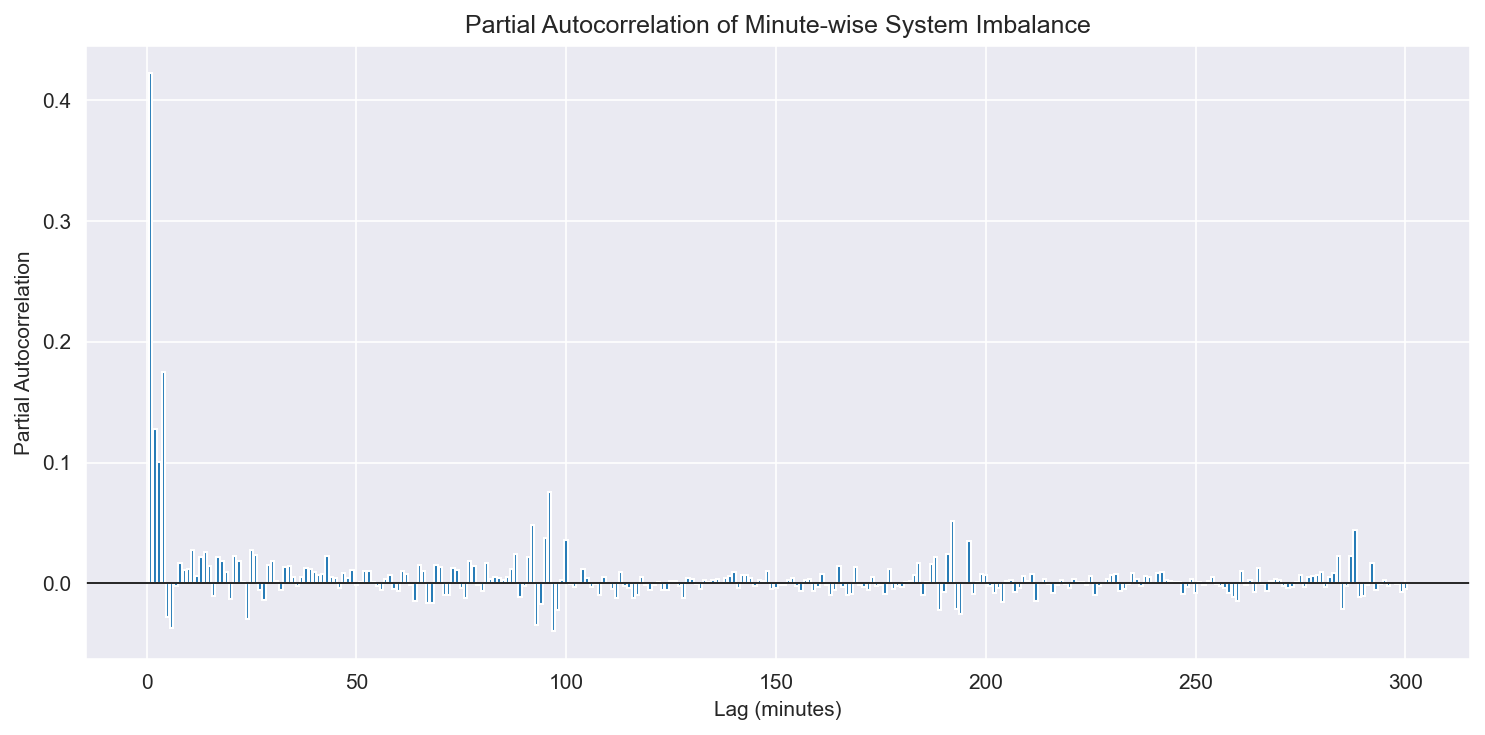

Top 50 PACF lags:
Lag 1: PACF = 0.4224
Lag 4: PACF = 0.1752
Lag 2: PACF = 0.1274
Lag 3: PACF = 0.1004
Lag 96: PACF = 0.0757
Lag 192: PACF = 0.0514
Lag 92: PACF = 0.0486
Lag 288: PACF = 0.0445
Lag 97: PACF = -0.0397
Lag 95: PACF = 0.0376
Lag 6: PACF = -0.0373
Lag 100: PACF = 0.0360
Lag 196: PACF = 0.0349
Lag 93: PACF = -0.0343
Lag 24: PACF = -0.0297
Lag 25: PACF = 0.0279
Lag 5: PACF = -0.0279
Lag 11: PACF = 0.0278
Lag 14: PACF = 0.0261
Lag 194: PACF = -0.0251
Lag 88: PACF = 0.0241
Lag 191: PACF = 0.0240
Lag 26: PACF = 0.0235
Lag 284: PACF = 0.0228
Lag 43: PACF = 0.0227
Lag 287: PACF = 0.0226
Lag 21: PACF = 0.0225
Lag 189: PACF = -0.0224
Lag 98: PACF = -0.0221
Lag 188: PACF = 0.0220
Lag 91: PACF = 0.0219
Lag 17: PACF = 0.0219
Lag 13: PACF = 0.0217
Lag 285: PACF = -0.0215
Lag 193: PACF = -0.0212
Lag 18: PACF = 0.0187
Lag 77: PACF = 0.0184
Lag 30: PACF = 0.0183
Lag 22: PACF = 0.0181
Lag 94: PACF = -0.0173
Lag 292: PACF = 0.0171
Lag 184: PACF = 0.0169
Lag 81: PACF = 0.0168
Lag 68: PACF = -0

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf

# --- Step 1: Choose your signal ---
series = df['system_imbalance_min_current_minute'].dropna()

# --- Step 2: Define number of lags ---
num_lags = 300  # or higher depending on your interest

# --- Step 3: Compute PACF ---
pacf_vals = pacf(series, nlags=num_lags, method='ywm')[1:]  # skip lag 0
lags = np.arange(1, num_lags + 1)

# --- Step 4: Plot ---
plt.figure(figsize=(10, 5), dpi=150)
plt.bar(lags, pacf_vals)
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Partial Autocorrelation of Minute-wise System Imbalance")
plt.xlabel("Lag (minutes)")
plt.ylabel("Partial Autocorrelation")
plt.tight_layout()
plt.show()
# Get top 20 lags with highest absolute PACF
pacf_dict = {lag: val for lag, val in zip(lags, pacf_vals)}
top_pacf_lags = sorted(pacf_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:50]

print("Top 50 PACF lags:")
for lag, val in top_pacf_lags:
    print(f"Lag {lag}: PACF = {val:.4f}")
